# Test Notebook

Import all necessary modules

In [1]:
import nest_asyncio
import asyncio
import schwabdev
from datetime import datetime, timedelta
from dotenv import load_dotenv
import time
import os
import json
import pandas as pd
import pytz
import numpy as np
import mplfinance as mpf
from IPython.display import display, clear_output
import warnings
from Multi_Strat_Back_Tester_Functions import *

Load environment variables from .env file for authentification purposes

In [2]:
load_dotenv()

True

Patches the notebook's running event loop so that it can handle multiple calls to `asyncio.run()` or other asynchronous methods without causing conflicts

In [3]:
nest_asyncio.apply()

Set the display options

In [4]:
# Display options
# Set the global float format to 4 decimal places
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.options.display.float_format = '{:,.4f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
pd.reset_option('display.max_rows') # Display default abbreviated rows

Create the client object.

In [5]:
app_key = os.getenv('app_key')
app_secret = os.getenv('app_secret')
callback_url = os.getenv('callback_url')

# Print them to verify (avoid printing sensitive info in production)
print(f"App Key: {app_key}")
print(f"App Secret: {app_secret}")
print(f"Callback URL: {callback_url}")

# Now proceed to initialize the client
client = schwabdev.Client(app_key, app_secret, callback_url)
print('Client initialized!')

App Key: 2C7Jh6zt5QdlSb0N5RnhWpaiEzKFr150
App Secret: OQGxH0GkD5bAEMA4
Callback URL: https://127.0.0.1
Client initialized!


Use this when in need of updating the refresh token.

In [6]:
# client.update_tokens(force=True)
# client = schwabdev.Client(app_key, app_secret, callback_url)

### Streamer Related Functions:

Ticker list and point value definition.

In [7]:
# tickers = "MARA,PLUG,SOFI,SWN,RKLB"
tickers = "/ES,/NQ,/CL,/GC"

ticker_to_point_value = {
    "/ES": 50,       # E-Mini S&P 500
    "/NQ": 20,       # E-Mini NASDAQ 100
    "/CL": 1000,     # Crude Oil
    "/GC": 100,      # Gold
}

ticker_to_tick_size = {
    "/ES": 0.25,        # E-Mini S&P 500
    "/NQ": 0.25,        # E-Mini NASDAQ 100
    "/CL": 0.01,        # Crude Oil
    "/GC": 0.1,         # Gold
}

Extracting and storing raw streaming data with two functions into ticker_tables dictionary. 

In [8]:
def extract_row_data(entry, content):
    
    # Create a row dictionary with the relevant fields
    row = { # For futures
        'timestamp': entry['timestamp'],
        'key': content.get('key', None),
        'bid_price': content.get('1', None),
        'ask_price': content.get('2', None),
        # 'last_price': last_price,  # Use updated last_price
        'last_price': content.get('3', None),
        'bid_size': content.get('4', None), # These two variables can be correlated 
        'ask_size': content.get('5', None), # with direction of price action
        'total_volume': content.get('8', None),
        'last_size': content.get('9', 0),
        'high_price': content.get('12', None),
        'low_price': content.get('13', None),
        'close_price': content.get('14', None),
        'open_price': content.get('18', None),
        'net_change': content.get('19', None),
        'future_pct_change': content.get('20', None),
        'open_interest': content.get('23', None),
        'tick': content.get('25', None),
        'tick_amount': content.get('26', None),
        'future_exp_date': content.get('35', None),
        'ask_time': content.get('37', None),
        'bid_time': content.get('38', None)}

    # row = { # For equities
    #     'timestamp': entry['timestamp'],               # Same
    #     'key': content.get('key', None),               # Same
    #     'bid_price': content.get('1', None),           # Matches bid_price
    #     'ask_price': content.get('2', None),           # Matches ask_price
    #     'last_price': last_price,                      # Matches last_price (updated)
    #     'bid_size': content.get('4', None),            # Matches bid_size
    #     'ask_size': content.get('5', None),            # Matches ask_size
    #     'total_volume': content.get('8', None),        # Matches total_volume
    #     'last_size': content.get('9', 0),              # Matches last_size
    #     'high_price': content.get('10', None),         # Matches high_price
    #     'low_price': content.get('11', None),          # Matches low_price
    #     'close_price': content.get('12', None),        # Matches close_price
    #     'open_price': content.get('17', None),         # Matches open_price
    #     'net_change': content.get('18', None),         # Matches net_change
    #     '52_week_high': content.get('19', None),       # Matches 52_week_high
    #     '52_week_low': content.get('20', None),        # Matches 52_week_low
    #     'pe_ratio': content.get('21', None),           # Matches pe_ratio
    #     'net_pct_change': content.get('42', None)}      # Matches net_pct_change  
    
    return row


In [9]:
# Initialize a dictionary to store DataFrames for each ticker
ticker_tables = {ticker: pd.DataFrame() for ticker in tickers.split(",")}

# Initialize a dictionary to store the last known price for each ticker
last_known_price = {ticker: None for ticker in tickers.split(",")}

def process_message_data(data):
    global ticker_tables, last_known_price
    
    # Loop through the content and extract the relevant fields
    if "data" in data:
        for entry in data['data']:
            if 'content' in entry:
                for content in entry['content']:
                    # Extract row data
                    row = extract_row_data(entry, content)

                    # Get the ticker (key) and last_price
                    ticker = row['key']
                    last_price = row.get('last_price')

                    # Check if last_price is None, if so use the last known price for the ticker
                    if last_price is None and ticker in last_known_price:
                        row['last_price'] = last_known_price[ticker]
                    else:
                        # Update the last known price
                        last_known_price[ticker] = last_price

                    # Convert the row dictionary to a DataFrame
                    row_df = pd.DataFrame([row])

                    # Check the ticker and append the row to the correct ticker table
                    if ticker in ticker_tables:
                        ticker_tables[ticker] = pd.concat([ticker_tables[ticker], row_df], ignore_index=True)

Compressing minute candles from the raw data.

In [10]:
minute_candles = {ticker: pd.DataFrame(columns=['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']) for ticker in tickers.split(",")}

def update_minute_candles(ticker_tables, time_frame='min'):
    global minute_candles

    for ticker, df in ticker_tables.items():
        if df.empty:
            continue
        
        # Ensure that 'datetime' column exists and is properly set
        if 'timestamp' in df.columns:
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('US/Eastern')

        # Ensure that the 'datetime' column is set as the DataFrame index (only if not already set)
        if df.index.name != 'datetime':
            df.set_index('datetime', inplace=True)

        # Group the data by minute intervals using 'min'
        current_minute = df.index.floor(time_frame)[-1]  # Get the most recent minute

        # Select only the rows from the most recent minute
        recent_data = df[df.index.floor(time_frame) == current_minute]

        if not recent_data.empty:
            # Extract OHLC values for the minute candle
            open_price = recent_data['last_price'].iloc[0]  # Open is the first last_price
            high_price = recent_data['last_price'].max()     # High is the max last_price
            low_price = recent_data['last_price'].min()      # Low is the min last_price
            close_price = recent_data['last_price'].iloc[-1] # Close is the last last_price
            total_volume = recent_data['total_volume'].max() # Total volume is the max value in this interval

            # Create a dictionary with the new candle data
            new_candle = {
                'datetime': current_minute,
                'ticker': ticker,
                'open': open_price,
                'high': high_price,
                'low': low_price,
                'close': close_price,
                'accumulative_volume': total_volume
            }

            # Convert the dictionary to a DataFrame and update the respective ticker's DataFrame in minute_candles
            new_candle_df = pd.DataFrame([new_candle])

            # Replace or append the most recent candle for this ticker
            if not minute_candles[ticker].empty and minute_candles[ticker]['datetime'].iloc[-1] == current_minute:
                minute_candles[ticker].iloc[-1] = new_candle  # Update the last candle
            else:
                minute_candles[ticker] = pd.concat([minute_candles[ticker], new_candle_df], ignore_index=True)  # Append new candle


Defining a function to calculate a price action envelope indicator for trend determination.

In [11]:
def calculate_price_action_envelope(df, high_col='high', low_col='low', window=5):
    """
    Calculate the continuous higher highs, higher lows, lower highs, and lower lows
    to create an envelope that wraps around the price action.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the price data.
    high_col (str): The column name for the high prices (default 'high').
    low_col (str): The column name for the low prices (default 'low').
    window (int): The window size for detecting local highs and lows (default 5).
    
    Returns:
    pd.DataFrame: The DataFrame with added columns for the price action envelope.
    """
    # Calculate rolling max (higher highs) and rolling min (lower lows)
    df['higher_high'] = df[high_col].rolling(window=window, min_periods=1).max()
    df['lower_low'] = df[low_col].rolling(window=window, min_periods=1).min()
    
    # Calculate rolling min of high for higher lows, and rolling max of low for lower highs
    df['higher_low'] = df[low_col].rolling(window=window, min_periods=1).min().cummax()
    df['lower_high'] = df[high_col].rolling(window=window, min_periods=1).max().cummin()
    
    # Create the envelope by combining these calculated values
    df['price_action_upper'] = df[['higher_high', 'lower_high']].max(axis=1)
    df['price_action_lower'] = df[['lower_low', 'higher_low']].min(axis=1)
    
    # Drop intermediate columns if not needed
    df.drop(columns=['higher_high', 'lower_low', 'higher_low', 'lower_high'], inplace=True)

    # Add moving averages for price_action_upper and price_action_lower
    ma_period = window  # Set the moving average period length to 5
    df['ma_price_action_upper'] = df['price_action_upper'].rolling(window=ma_period, min_periods=1).mean()
    df['ma_price_action_lower'] = df['price_action_lower'].rolling(window=ma_period, min_periods=1).mean()

    # # Define a function to calculate trend score for an entire column over a 5-period window
    # def calculate_trend_score(col_series):
    #     score_series = []
    #     for i in range(len(col_series)):
    #         score = 0
    #         for j in range(1, window):
    #             if i - j >= 0:
    #                 if col_series.iloc[i] > col_series.iloc[i - j]:
    #                     score += 5
    #                 elif col_series.iloc[i] < col_series.iloc[i - j]:
    #                     score -= 5
    #         score_series.append(score)
    #     return score_series
    
    # # Calculate the trend indicator score for each relevant column and combine them
    # scores_upper = calculate_trend_score(df['price_action_upper'])
    # scores_lower = calculate_trend_score(df['price_action_lower'])
    # scores_ma_upper = calculate_trend_score(df['ma_price_action_upper'])
    # scores_ma_lower = calculate_trend_score(df['ma_price_action_lower'])
    
    # # Sum the scores for the final trend indicator
    # total_score = [u + l + mu + ml for u, l, mu, ml in zip(scores_upper, scores_lower, scores_ma_upper, scores_ma_lower)]
    
    # # Rescale total_score to a 0-100 range and assign to 'trend_indicator'
    # df['trend_indicator'] = [(score + 100) / 2 for score in total_score]

    # Uncomment this function to unfuck things. Revert to check_moving_average cell 4

    # Define a function to calculate trend score for an entire column over a 5-period window
    def calculate_trend_score(col_series):
        score_series = []
        for i in range(len(col_series)):
            score = 0
            for j in range(1, window):
                if i - j >= 0:
                    if col_series.iloc[i] > col_series.iloc[i - j]:
                        score += 10
                    elif col_series.iloc[i] < col_series.iloc[i - j]:
                        score -= 10
            score_series.append(score)
        return score_series

    # Calculate the trend indicator score for each relevant column and combine them
    scores_upper = calculate_trend_score(df['price_action_upper'])
    scores_lower = calculate_trend_score(df['price_action_lower'])

    # Sum the scores for the final trend indicator based only on price_action_upper and price_action_lower
    total_score = [u + l for u, l in zip(scores_upper, scores_lower)]

    # Rescale total_score to a 0-100 range and assign to 'trend_indicator'
    df['trend_indicator'] = [(score + 100) / 2 for score in total_score]

    return df

    # # Define a function to calculate trend score based on the 5-period window
    # def calculate_trend_score(col_series):
    #     score_series = []
    #     for i in range(len(col_series)):
    #         if i >= window:  # Ensure we have a full 5-period window
    #             # Calculate the differences over the last 5 periods
    #             diffs = col_series[i - window + 1: i + 1].diff()
    #             # Apply scoring based on whether values increased, decreased, or stayed the same
    #             score = sum(
    #                 20 if diff > 0 else -20 if diff < 0 else 0
    #                 for diff in diffs[1:]  # Ignore the first NaN from diff()
    #             )
    #         else:
    #             score = 0  # Not enough data for a full 5-period window
    #         score_series.append(score)
    #     return score_series

    # # Calculate the trend indicator score for each relevant column
    # df['upper_envelope_score'] = calculate_trend_score(df['high'])
    # df['lower_envelope_score'] = calculate_trend_score(df['low'])

    # # Sum the scores for the final trend indicator based only on price_action_upper and price_action_lower
    # total_score = [u + l for u, l in zip(df['upper_envelope_score'], df['lower_envelope_score'])]

    # # Rescale total_score to a 0-100 range and assign to 'trend_indicator'
    # df['trend_indicator'] = [(score + 100) / 2 for score in total_score]

    # return df

A function that calculates a number of indicators.

In [12]:
def calculate_indicators(df, price_col='close', acc_vol_col='accumulative_volume', sma_periods=None, wma_periods=None, rsi_periods=None, volume_col='volume', candle_window=10):
    """
    Calculate SMAs and WMAs for given periods and append them to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the price data.
    price_col (str): The column name for the price data (default 'close').
    acc_vol_col (str): The column name for the accumulative volume data (default 'accumulative_volume').
    sma_periods (list): A list of periods for SMAs (e.g., [3, 5, 10, 20]).
    wma_periods (list): A list of periods for WMAs (e.g., [3, 5, 10, 20]).
    volume_col (str): The column name to store the volume difference (default 'volume').
    
    Returns:
    pd.DataFrame: The DataFrame with the calculated SMAs and WMAs appended.
    """
    # Calculate volume differences
    df[volume_col] = df[acc_vol_col].diff()
    
    # Calculate SMAs
    if sma_periods:
        for period in sma_periods:
            sma_col_name = f'sma_{period}'
            df[sma_col_name] = df[price_col].rolling(window=period).mean()
    
    # Calculate WMAs
    if wma_periods:
        for period in wma_periods:
            weights = np.arange(1, period + 1)  # Generate weights from 1 to the period length
            wma_col_name = f'wma_{period}'
            df[wma_col_name] = df[price_col].rolling(window=period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

    # calculate_vwap_and_bands(df, high_col='high', low_col='low', close_col='close', volume_col='volume')

    # Assume 'periods' is a predefined list of different periods for which you want to calculate RSI
    for period in rsi_periods:
        # Calculate RSI for each period
        delta = df[price_col].diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
        rs = gain / loss
        df[f'rsi_{period}'] = 100 - (100 / (1 + rs))

    # Calculate price action envelope
    df = calculate_price_action_envelope(df, high_col='high', low_col='low', window=5)

    df['ohlc_average'] = df[['open', 'high', 'low', 'close']].mean(axis=1)
    df['candle_span'] = df['high'] - df['low']
    df['candle_body'] = (df['close'] - df['open']).abs()
    df['candle_span_avg'] = df['candle_span'].rolling(window=candle_window, min_periods=1).mean()
    df['candle_span_max'] = df['candle_span'].rolling(window=candle_window, min_periods=1).max()
    df['candle_span_maxavg_mean'] =(df['candle_span_avg'] + df['candle_span_max'])/2
    df['hundred_line'] = 100
    df['fifty_line'] = 50
    df['zero_line'] = 0
    df['trend_high_threshold'] = 75
    df['trend_low_threshold'] = 25

    return df

## Trade Logic Variations

In [13]:
# def check_moving_average(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', signal_column='signal_wma_5_sma_5', signal_column_2='signal_rsi_5'):
#     """ # no stop losses
#     Function to check if the moving average is above or below another moving average for each row.
    
#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing candle data.
#     - ma_name1 (str): The column name for the first moving average (default is 'wma_5').
#     - ma_name2 (str): The column name for the second moving average (default is 'sma_5').
    
#     Returns:
#     - candles (pd.DataFrame): The DataFrame with an updated 'signal' column.
#     """
#     current_time_USE = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S')
#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour    
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Remove columns if they already exist before creating them
#     columns_to_remove = [f'signal_{ma_name1}_{ma_name2}', f'signal_{rsi_column}', 'stop_loss_ma', 'stop_loss_rsi']
#     for col in columns_to_remove:
#         if col in candles.columns:
#             candles.drop(columns=[col], inplace=True)
#             print(f"{current_time_USE}: Dropped existing column '{col}' to recalculate.")

#     # Check if the moving average and RSI columns exist and have valid data
#     if ma_name1 in candles.columns and ma_name2 in candles.columns:
        
#         # Iterate through each row to compare the values of 'wma_5', 'sma_5'
#         for i, row in candles.iterrows():
#             # Check moving average condition
#             if pd.notna(row[ma_name1]) and pd.notna(row[ma_name2]):
#                 if row[ma_name1] > row[ma_name2]:
#                     candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # wma_5 is above sma_5
#                     # print(f"{current_time_USE}: {ma_name1} {row[ma_name1]} is ABOVE {ma_name2} {row[ma_name2]}")
#                 elif row[ma_name1] < row[ma_name2]:
#                     candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 1  # wma_5 is below sma_5
#                     # print(f"{current_time_USE}: {ma_name1} {row[ma_name1]} is BELOW {ma_name2} {row[ma_name2]}")
#                 else:
#                     candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # wma_5 is equal to sma_5
#                     # print(f"{current_time_USE}: {ma_name1} {row[ma_name1]} is EQUAL to {ma_name2} {row[ma_name2]}")
#             else:
#                 candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # If any data is missing, set signal to 0
#                 # print(f"{current_time_USE}: Insufficient data for {ma_name2} or {ma_name1} for index {i}")

#     else:
#         # If columns are missing, set the whole column to 0 (no signal)
#         print(f"{current_time_USE}: Either {ma_name1} or {ma_name2} do not exist in {candles}")                

#     if rsi_column in candles.columns:
            
#         for i, row in candles.iterrows():    

#             # Generate signals based on RSI
#             if pd.notna(row[rsi_column]):
#                 if row[rsi_column] > 50:
#                     candles.at[i, f'signal_{rsi_column}'] = 0  # RSI above 50
#                     # print(f"{current_time_USE}: RSI {row[rsi_column]} is ABOVE 50")
#                 elif row[rsi_column] < 50:
#                     candles.at[i, f'signal_{rsi_column}'] = 1  # RSI below 50
#                     # print(f"{current_time_USE}: RSI {row[rsi_column]} is BELOW 50")
#                 elif row[rsi_column] == 50:
#                     candles.at[i, f'signal_{rsi_column}'] = 1  # RSI at 50
#                     # print(f"{current_time_USE}: RSI {row[rsi_column]} is EQUAL to 50")
#             else:
#                 candles.at[i, f'signal_{rsi_column}'] = 0  # Handle missing data for RSI
#                 # print(f"{current_time_USE}: Insufficient data for {rsi_column} at index {i}")

#     else:
#         # If columns are missing, set the whole column to 0 (no signal)
#         print(f"{current_time_USE}: {rsi_column} does not exist in {candles}")

#     return candles

In [14]:
# def check_moving_average(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', signal_column='signal_wma_5_sma_5', signal_column_2='signal_rsi_5'):
#     """ # with stop losses
#     Function to check if the moving average is above or below another moving average for each row.
#     Also, it will go market neutral if the price drops more than candle_span_maxavg_mean from the entry price.
    
#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing candle data.
#     - ma_name1 (str): The column name for the first moving average (default is 'wma_5').
#     - ma_name2 (str): The column name for the second moving average (default is 'sma_5').
#     - rsi_column (str): The column name for the RSI indicator (default is 'rsi_5').
    
#     Returns:
#     - candles (pd.DataFrame): The DataFrame with updated 'signal' and neutral markers.
#     """
#     current_time_USE = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S')

#     ma_position_open = False
#     ma_entry_price = None
#     rsi_position_open = False
#     rsi_entry_price = None

#     # Iterate through each row in the candles DataFrame
#     for i, row in candles.iterrows():

#         # Moving Average Strategy
#         if pd.notna(row[ma_name1]) and pd.notna(row[ma_name2]):
#             if not ma_position_open and row[ma_name1] > row[ma_name2]:
#                 # Open position if wma_5 is above sma_5
#                 ma_position_open = True
#                 ma_entry_price = row['close']
#                 candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # Signal to go long
#                 candles.at[i, 'stop_loss_ma'] = ma_entry_price - row['candle_span_maxavg_mean']
#             elif ma_position_open and row['close'] < ma_entry_price - row['candle_span_maxavg_mean']:
#                 # Go market neutral if the price drops below the stop loss level
#                 ma_position_open = False
#                 candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = -1  # Signal to go market neutral
#             elif ma_position_open and row[ma_name1] < row[ma_name2]:
#                 # Close position if wma_5 goes below sma_5
#                 ma_position_open = False
#                 candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 1  # Signal to go short

#         # RSI Strategy
#         if pd.notna(row[rsi_column]):
#             if not rsi_position_open and row[rsi_column] < 50:
#                 # Open position if RSI is below 50
#                 rsi_position_open = True
#                 rsi_entry_price = row['close']
#                 candles.at[i, f'signal_{rsi_column}'] = 0  # Signal to go long
#                 candles.at[i, 'stop_loss_rsi'] = rsi_entry_price - row['candle_span_maxavg_mean']
#             elif rsi_position_open and row['close'] < rsi_entry_price - row['candle_span_maxavg_mean']:
#                 # Go market neutral if the price drops below the stop loss level
#                 rsi_position_open = False
#                 candles.at[i, f'signal_{rsi_column}'] = -1  # Signal to go market neutral
#             elif rsi_position_open and row[rsi_column] > 50:
#                 # Close position if RSI goes above 50
#                 rsi_position_open = False
#                 candles.at[i, f'signal_{rsi_column}'] = 1  # Signal to exit

#     return candles

In [15]:
tick_size = ticker_to_tick_size.get("/ES")
tick_size

0.25

In [16]:
def check_moving_average(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'): # , signal_column='signal_wma_5_sma_5', signal_column_2='signal_rsi_5'
    """ An attempt at implementing ma_stop_loss_hit logic into the function. produces some whacky results
    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): The column name for the first moving average (default is 'wma_5').
    - ma_name2 (str): The column name for the second moving average (default is 'sma_5').
    - rsi_column (str): The column name for the RSI indicator (default is 'rsi_5').
    
    Returns:
    - candles (pd.DataFrame): The DataFrame with updated 'signal' and stop loss values.
    """
    current_time_USE = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S')

    ma_position_open = False  # Initialize the MA position to neutral
    ma_entry_price = None     # Initialize the MA entry price to None
    ma_stop_loss_hit = False  # Track if a stop loss has been hit

    rsi_position_open = False # Initialize the RSI position to neutral
    rsi_entry_price = None    # Initialize the RSI entry price to None

    try:

        # Iterate through each row in the candles DataFrame
        for i, row in candles.iterrows():

            # # Moving Average Strategy
            if ma_stop_loss_hit: # This is the wonky one with reverse logic. Behaves strangely with respect to stop losses and entries/exits
                # If stop loss was hit, stay neutral as long as ma_name1 remains below ma_name2
                if row[ma_name1] < row[ma_name2]:
                    ma_stop_loss_hit = True  # Reset stop loss hit state
                candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # Stay market neutral
                candles.at[i, 'stop_loss_ma'] = None  # No active stop loss
                continue

            # if pd.notna(row[ma_name1]) and pd.notna(row[ma_name2]): # Uncomment this line and indent the following chunk to undo fuckery                # If neither MA column is all null, then proceed
            if not ma_position_open and row[ma_name1] <= row[ma_name2]:                                 # If no position is open and wma is below or equal to sma
                ma_position_open = True                                                                 # Set the MA position to open
                ma_entry_price = row['close']                                                           # Record the entry price for use in determining stop loss
                candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 1                                      # Set the MA signal column to long (1)
                candles.at[i, 'stop_loss_ma'] = (ma_entry_price - row['candle_span_max'])       # Set the stop loss level
            elif ma_position_open and row['close'] < (ma_entry_price - row['candle_span_max']): # If the price drops below the stop loss level
                ma_position_open = False                                                                # Set the MA position to neutral
                candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0                                      # Set the MA signal column to neutral (0)
                candles.at[i, 'stop_loss_ma'] = None                                                    # Reset stop loss after it's triggered
            elif ma_position_open and row[ma_name1] > row[ma_name2]:                                    # If a position is open and wma is above sma
                ma_position_open = False                                                                # Set the MA position to neutral
                candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0                                      # Set the MA signal column to neutral (0)
                candles.at[i, 'stop_loss_ma'] = None                                                    # Reset stop loss after closing the position due to MA crossover opposite day
            elif ma_position_open:                                                                      # If a position is still open past the closing conditions
                candles.at[i, 'stop_loss_ma'] = candles.at[i-1, 'stop_loss_ma']                         # Retain the stop loss value for risk management and visualization

            # # RSI Strategy
            # if pd.notna(row[rsi_column]): # Uncomment this line and indent the following chunk to undo fuckery                                                               # If the RSI column is not all null, then proceed
            if not rsi_position_open and row[rsi_column] < 50:                                          # If no position is open and RSI is below 50
                rsi_position_open = True                                                                # Set the RSI position to open
                rsi_entry_price = row['close']                                                          # Record the entry price for use in determining stop loss
                candles.at[i, f'signal_{rsi_column}'] = 1                                               # Set the RSI signal column to long (1)
                candles.at[i, 'stop_loss_rsi'] = rsi_entry_price - row['candle_span_max']       # Set the stop loss level
            elif rsi_position_open and row['close'] < rsi_entry_price - row['candle_span_max']: # If a position is open and the price drops below the stop loss level
                rsi_position_open = False                                                               # Set the RSI position to neutral
                candles.at[i, f'signal_{rsi_column}'] = 0                                               # Set the RSI signal column to neutral (0)
                candles.at[i, 'stop_loss_rsi'] = None                                                   # Reset stop loss after it's triggered
            elif rsi_position_open and row[rsi_column] >= 50:                                           # If a position is open and RSI is above or equal to 50
                rsi_position_open = False                                                               # Set the RSI position to neutral
                candles.at[i, f'signal_{rsi_column}'] = 0                                               # Set the RSI signal column to neutral (0)
                candles.at[i, 'stop_loss_rsi'] = None                                                   # Reset stop loss after closing the position due to RSI crossover opposite day
            elif rsi_position_open:                                                                     # If a position is still open past the closing conditions
                candles.at[i, 'stop_loss_rsi'] = candles.at[i-1, 'stop_loss_rsi']                       # Retain the stop loss value for risk management and visualization

    except:
        print('Something weird is happening in the check_moving_average function.')

    return candles


In [17]:
# def check_moving_average(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
#     """ # Refined more complex logic, uses trend_indicator to adjust strategy for MA crossover, stop losses potentially improved- investiagte further
#     Function to check if the moving average is above or below another moving average for each row.
#     - Sets stop loss only on opening trades.
#     - Resets stop loss when position is neutral.
#     - Applies trend indicator adjustments:
#       - If 'trend_indicator' > 75, reverse MA logic.
#       - If 'trend_indicator' < 25, stay market neutral.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing candle data.
#     - ma_name1 (str): The column name for the first moving average (default is 'wma_5').
#     - ma_name2 (str): The column name for the second moving average (default is 'sma_5').
#     - rsi_column (str): The column name for the RSI indicator (default is 'rsi_5').

#     Returns:
#     - candles (pd.DataFrame): The DataFrame with updated 'signal' and stop loss values.
#     """
#     ma_position_open = False  # Initialize MA position status as closed
#     ma_entry_price = None     # Initialize MA entry price as nothing yet
#     rsi_position_open = False # Initialize RSI position status as closed
#     rsi_entry_price = None    # Initialize RSI entry price as nothing yet

#     for i, row in candles.iterrows():                          # Iterate through each row in the candles DataFrame
#                                                                # Apply Trend Indicator Adjustments
#         if row.get('trend_indicator') > 75:                # If the trend indicator is above 75
#                                                                # Reverse the moving average logic
#             ma_long_condition = row[ma_name1] < row[ma_name2]  # If wma is below sma, open position
#             ma_close_condition = row[ma_name1] > row[ma_name2] # If wma is above sma, close position
#         elif row.get('trend_indicator') < 25:              # If the trend indicator is below 25
#                                                                # Force market neutral
#             ma_position_open = False                           # Close any open MA position
#             rsi_position_open = False                          # Close any open RSI position
#             candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0 # Set the MA signal column to neutral (0)
#             candles.at[i, f'signal_{rsi_column}'] = 0          # Set the RSI signal column to neutral (0)
#             candles.at[i, 'stop_loss_ma'] = None               # Reset MA stop loss
#             candles.at[i, 'stop_loss_rsi'] = None              # Reset RSI stop loss
#             continue                                           # Skip to the next row
#         else:
#                                                                # Normal logic
#             ma_long_condition = row[ma_name1] > row[ma_name2]  # If wma is above sma, open position
#             ma_close_condition = row[ma_name1] < row[ma_name2] # If wma is below sma, close position

#         # Moving Average Strategy
#         if pd.notna(row[ma_name1]) and pd.notna(row[ma_name2]):                                         # If neither MA column is all null, then proceed
#             if not ma_position_open and ma_long_condition:                                              # If no position is open and wma is above sma
#                                                                                                         # Open MA position
#                 ma_position_open = True                                                                 # Set the MA position to open
#                 ma_entry_price = row['close']                                                           # Record the entry price for use in determining stop loss
#                 candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 1                                      # Set the MA signal column to long (1)
#                 candles.at[i, 'stop_loss_ma'] = ma_entry_price - row['candle_span_maxavg_mean']         # Set the MA stop loss level
#             elif ma_position_open and row['close'] < (ma_entry_price - row['candle_span_maxavg_mean']): # If there is an MA position open and the price drops below the stop loss level
#                                                                                                         # Close position if price drops below stop loss
#                 ma_position_open = False                                                                # Set the MA position to neutral
#                 candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0                                      # Set the MA signal column to neutral (0)
#                 candles.at[i, 'stop_loss_ma'] = None                                                    # Reset stop loss after it's triggered
#             elif ma_position_open and ma_close_condition:                                               # If there is an MA position open and wma is below sma
#                                                                                                         # Close position if moving average cross occurs in opposite direction
#                 ma_position_open = False                                                                # Set the MA position to neutral
#                 candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0                                      # Set the MA signal column to neutral (0)
#                 candles.at[i, 'stop_loss_ma'] = None                                                    # Reset stop loss after closing the position due to MA crossover opposite day
#             elif ma_position_open:                                                                      # If there is an MA position open
#                                                                                                         # Retain the stop loss level
#                 candles.at[i, 'stop_loss_ma'] = candles.at[i-1, 'stop_loss_ma']                         # Retain the stop loss value for risk management and visualization

#         # RSI Strategy
#         if pd.notna(row[rsi_column]):                                                                   # If the RSI column is not all null, then proceed
#             if not rsi_position_open and row[rsi_column] < 50:                                          # If no position is open and RSI is below 50
#                                                                                                         # Open RSI position
#                 rsi_position_open = True                                                                # Set the RSI position to open
#                 rsi_entry_price = row['close']                                                          # Record the entry price for use in determining stop loss
#                 candles.at[i, f'signal_{rsi_column}'] = 1                                               # Set the RSI signal column to long (1)
#                 candles.at[i, 'stop_loss_rsi'] = rsi_entry_price - row['candle_span_maxavg_mean']       # Set the RSI stop loss level
#             elif rsi_position_open and row['close'] < rsi_entry_price - row['candle_span_maxavg_mean']: # If there is an RSI position open and the price drops below the stop loss level
#                                                                                                         # Close position if price drops below stop loss
#                 rsi_position_open = False                                                               # Set the RSI position to neutral
#                 candles.at[i, f'signal_{rsi_column}'] = 0                                               # Set the RSI signal column to neutral (0)
#                 candles.at[i, 'stop_loss_rsi'] = None                                                   # Reset stop loss after it's triggered
#             elif rsi_position_open and row[rsi_column] >= 50:                                           # If there is an RSI position open and RSI is above or equal to 50
#                                                                                                         # Close position if RSI crosses back up to 50 or higher
#                 rsi_position_open = False                                                               # Set the RSI position to neutral
#                 candles.at[i, f'signal_{rsi_column}'] = 0                                               # Set the RSI signal column to neutral (0)
#                 candles.at[i, 'stop_loss_rsi'] = None                                                   # Reset stop loss after closing the position due to RSI crossover opposite day
#             elif rsi_position_open:                                                                     # If there is an RSI position open
#                                                                                                         # Retain the stop loss level
#                 candles.at[i, 'stop_loss_rsi'] = candles.at[i-1, 'stop_loss_rsi']                       # Retain the stop loss value for risk management and visualization

#     return candles

The newest signal marker generator. Trying to modify it to only handle two different market states- long and neutral.

In [18]:
def add_signal_markers_long_only(df, 
                                 signal_column='signal_column', 
                                 price_col='close', 
                                 buy_marker='buy_marker', 
                                #  sell_marker='sell_marker', 
                                 neutral_marker='neutral_marker'):
    """
    Adds columns for buy, sell, and market neutral signal markers in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the trading data.
    - signal_column (str): The name of the column containing the trading signals.
    """
    df[buy_marker] = None
    # df[sell_marker] = None
    df[neutral_marker] = None  # Add a column for market neutral markers

    previous_signal = df[signal_column].shift(1)
    signal_changes = df[signal_column] != previous_signal

    for idx, signal in df[signal_changes].iterrows():
        if signal[signal_column] == 1:
            df.at[idx, buy_marker] = signal[price_col]
        # elif signal[signal_column] == -1:
        #     df.at[idx, sell_marker] = signal[price_col]
        elif signal[signal_column] == 0:
            df.at[idx, neutral_marker] = signal[price_col]

    return df

This handles profit curve calculations. Need to incorporate bid/ask spread, which is typically only a tick size.

In [19]:
def calculate_profit_loss(candles, signal_ma='signal_wma_5_sma_5', signal_rsi='signal_rsi_5', multiplier=1): # multiplier=?? for stocks, multiplier=50 for ES
    """
    Function to calculate profit and loss based on the buy/sell signals and price movement.
    Assumes you're buying one share at a time and selling it to exit. No short selling.
    
    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data and signal columns.

    Returns:
    - candles (pd.DataFrame): The DataFrame with 'pnl_ma' and 'pnl_rsi' columns showing profit/loss for each trade.
    """
    
    # Add columns to store profit/loss for each strategy
    candles['pnl_ma'] = None
    candles['pnl_rsi'] = None
    
    ma_position_open = False
    rsi_position_open = False
    
    ma_buy_price = None
    rsi_buy_price = None

    try:    
        for i, row in candles.iterrows():
            # Moving Average Strategy
            if row[signal_ma] == 1 and not ma_position_open:
                # Buy condition for MA
                ma_buy_price = row['close']
                ma_position_open = True
                candles.at[i, 'pnl_ma'] = 0  # No PnL on the buy
                # print(f"MA Buy at {ma_buy_price}")
                
            elif row[signal_ma] == 0 and ma_position_open:
                # Sell condition for MA (exit position)
                ma_sell_price = row['close']
                ma_position_open = False
                # Calculate profit
                candles.at[i, 'pnl_ma'] = (ma_sell_price - ma_buy_price)*multiplier
                # print(f"MA Sell at {ma_sell_price}, PnL: {ma_sell_price - ma_buy_price}")
                
            # RSI Strategy
            if row[signal_rsi] == 1 and not rsi_position_open:
                # Buy condition for RSI
                rsi_buy_price = row['close']
                rsi_position_open = True
                candles.at[i, 'pnl_rsi'] = 0  # No PnL on the buy
                # print(f"RSI Buy at {rsi_buy_price}")
                
            elif row[signal_rsi] == 0 and rsi_position_open:
                # Sell condition for RSI (exit position)
                rsi_sell_price = row['close']
                rsi_position_open = False
                # Calculate profit
                candles.at[i, 'pnl_rsi'] = (rsi_sell_price - rsi_buy_price)*multiplier
                # print(f"RSI Sell at {rsi_sell_price}, PnL: {rsi_sell_price - rsi_buy_price}")
        
        # Replace any NaN values with 0 (if no trade happened on that row)
        candles['pnl_ma'].fillna(0, inplace=True)
        candles['pnl_rsi'].fillna(0, inplace=True)
        candles['cum_pnl_ma'] = candles['pnl_ma'].cumsum()
        candles['cum_pnl_rsi'] = candles['pnl_rsi'].cumsum()
        candles['cum_pnl_all'] = candles['cum_pnl_ma'] + candles['cum_pnl_rsi']

        # Add buy, sell, and neutral markers if signal_column exists
        if signal_ma:
            candles = add_signal_markers_long_only(candles, 
                                                signal_ma, 
                                                price_col='close')
        else:
            print('signal_ma must be missing')

        if signal_rsi:
            candles = add_signal_markers_long_only(candles, 
                                                signal_rsi, 
                                                price_col='close', 
                                                buy_marker='buy_marker_2', 
                                                #    sell_marker='sell_marker_2', 
                                                neutral_marker='neutral_marker_2')
        else:
            print('signal_rsi must be missing')
    except:
        print('Something weird going on in calculate_profit_loss')
        
    return candles

A function for plotting all of the different data together to create a whole picture of what the strategy is doing for any given ticker.

In [20]:
def plot_moving_averages(df, ma1='wma_5', ma2='sma_5', rsi_plt='rsi_5', signal_column='signal_wma_5_sma_5', signal_column_2='signal_rsi_5', 
                         figsize=(40, 20), font_size=10, ma_markersize=50, signal_markersize_y=600, signal_markersize_b=500, v_if_short='o'): #'v' if short enabled, 'o' if not
    """
    Plots the minute_candles DataFrame with two selected moving averages and optional RSI.
    Also plots cumulative profit for MA and RSI strategies on a secondary axis.

    Parameters:
    - ma1 (str): The column name of the first moving average to plot.
    - ma2 (str): The column name of the second moving average to plot.
    - signal_column (str): The column name of the signal data (default is 'signal').
    - figsize (tuple): The size of the plot (width, height) in inches (default is (30, 20)).
    """
    try:
        # Clean the data to ensure numeric columns are valid
        columns_to_convert = ['open', 'high', 'low', 'close', 'volume', ma1, ma2, rsi_plt]
        df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

        # Select the columns to plot
        plot_data = df[['datetime', 'open', 'high', 'low', 'close', 'volume', ma1, ma2, rsi_plt]].copy()
        plot_data.set_index('datetime', inplace=True)

        # Create the additional plots for the moving averages and RSI, but only if they are warmed up
        add_plots = []

        # Check if the moving averages have enough valid data to plot
        if not df[ma1].isnull().all() and not df[ma2].isnull().all():
            add_plots.append(mpf.make_addplot(plot_data[ma1], color='yellow', type='scatter', marker='o', markersize=ma_markersize, label=f'{ma1}'))
            add_plots.append(mpf.make_addplot(plot_data[ma1], color='yellow', linestyle='-', width=0.75))
            add_plots.append(mpf.make_addplot(plot_data[ma2], color='purple', type='scatter', marker='o', markersize=ma_markersize, label=f'{ma2}'))
            add_plots.append(mpf.make_addplot(plot_data[ma2], color='purple', linestyle='-', width=0.75))
        else:
            print("Moving averages have not warmed up yet. Plotting without them.")

        # Check if the RSI has enough valid data to plot
        if not df[rsi_plt].isnull().all():
            add_plots.append(mpf.make_addplot(df[rsi_plt], panel=2, color='blue', type='scatter', marker='o', markersize=ma_markersize, label='RSI'))
            add_plots.append(mpf.make_addplot(df[rsi_plt], panel=2, color='blue', linestyle='-', width=0.75))
            add_plots.append(mpf.make_addplot(df['trend_indicator'], panel=2, color='white', type='scatter', marker='o', markersize=ma_markersize, label='RSI'))
            add_plots.append(mpf.make_addplot(df['trend_indicator'], panel=2, color='white', linestyle='-', width=0.75))
            add_plots.append(mpf.make_addplot(df['hundred_line'], panel=2, color='red', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(df['fifty_line'], panel=2, color='yellow', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(df['zero_line'], panel=2, color='green', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(df['trend_high_threshold'], panel=2, color='white', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(df['trend_low_threshold'], panel=2, color='white', linestyle=':', secondary_y=False))
        else:
            print("RSI has not warmed up yet. Plotting without it.")

        # Add buy, sell, and neutral markers if signal_column exists. Eliminate the if else statement to revert to working order
        if 'buy_marker' in df.columns and 'neutral_marker' in df.columns:
            add_plots.append(mpf.make_addplot(df['buy_marker'], type='scatter', marker='^', markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))
            # add_plots.append(mpf.make_addplot(df['sell_marker'], type='scatter', marker=v_if_short, markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))
            add_plots.append(mpf.make_addplot(df['neutral_marker'], type='scatter', marker='o', markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))
        else:
            print("Buy/Sell markers for MA strat have not warmed up yet. Plotting without them.")

        # Add buy, sell, and neutral markers for RSI strategy
        if 'buy_marker_2' in df.columns and 'neutral_marker_2' in df.columns:
            add_plots.append(mpf.make_addplot(df['buy_marker_2'], type='scatter', marker='^', markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))
            # add_plots.append(mpf.make_addplot(df['sell_marker_2'], type='scatter', marker=v_if_short, markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))
            add_plots.append(mpf.make_addplot(df['neutral_marker_2'], type='scatter', marker='o', markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))
        else:
            print("Buy/Sell markers for RSI strat have not warmed up yet. Plotting without them.")

        # Add cumulative profit plots on a secondary y-axis
        add_plots.append(mpf.make_addplot(df['cum_pnl_ma'], panel=0, color='yellow', secondary_y=True, label='Cumulative PnL (MA)', linestyle='-', width=1.25))
        add_plots.append(mpf.make_addplot(df['cum_pnl_rsi'], panel=0, color='blue', secondary_y=True, label='Cumulative PnL (RSI)', linestyle='-', width=1.25))
        add_plots.append(mpf.make_addplot(df['cum_pnl_all'], panel=0, color='green', secondary_y=True, label='Cumulative PnL (Combined)', linestyle='-', width=1.25))

        # Add stop-loss markers (x) for both MA and RSI strategies
        # if 'stop_loss_ma' in df.columns:
        add_plots.append(mpf.make_addplot(df['stop_loss_ma'], type='scatter', marker='x', markersize=200, color='yellow', panel=0, secondary_y=False))
        # else:
        #     print("There are no stop loss markers for MA strat")
        # if 'stop_loss_rsi' in df.columns:
        add_plots.append(mpf.make_addplot(df['stop_loss_rsi'], type='scatter', marker='x', markersize=100, color='blue', panel=0, secondary_y=False))
        # else:
        #     print("There are no stop loss markers for RSI strat")

        # Add price action envelope as white lines
        if 'price_action_upper' in df.columns and 'price_action_lower' in df.columns:
            add_plots.append(mpf.make_addplot(df['price_action_upper'], color='white', linestyle='-', width=0.5, label='Price Action Upper'))
            add_plots.append(mpf.make_addplot(df['price_action_lower'], color='white', linestyle='-', width=0.5, label='Price Action Lower'))
            # add_plots.append(mpf.make_addplot(df['ma_price_action_upper'], color='white', linestyle='-', width=0.5, label='Price Action Upper'))
            # add_plots.append(mpf.make_addplot(df['ma_price_action_lower'], color='white', linestyle='-', width=0.5, label='Price Action Lower'))
        else:
            print("Price action envelope not calculating properly")

        # Create a custom style with a black background
        black_style = mpf.make_mpf_style(
            base_mpf_style='charles',  # Start with the 'charles' style and modify it
            facecolor='black',         # Set the background color to black
            gridcolor='black',          # Set the grid line color
            edgecolor='purple',          # Set the edge color for candles and boxes
            figcolor='black',          # Set the figure background color to black
            rc={'axes.labelcolor': 'yellow', 
                'xtick.color': 'yellow', 
                'ytick.color': 'yellow', 
                'axes.titlecolor': 'yellow',
                'font.size': font_size, 
                'axes.labelsize': font_size,
                'axes.titlesize': font_size,
                'xtick.labelsize': font_size,
                'ytick.labelsize': font_size,
                'legend.fontsize': font_size}  # Set tick and label colors to white
        )

        # Plot using mplfinance
        mpf.plot(plot_data, type='candle', style=black_style, 
                title='',
                ylabel='Price', 
                addplot=add_plots, 
                figsize=figsize,
                volume=True,
                panel_ratios=(8, 2),
                #  panel_ratios=(8, 2, 2),             
                tight_layout=True)
    except Exception as e:
        print(f"Something wrong in the plotting_moving_averages function: {e}")

A function for processing the visualization of all dataframes in the minute_candles dictionary of dfs.

In [21]:
def visualize_trades(candles, lower_slice=0, upper_slice=-1):
    # Iterate through the minute_candles dictionary
    for ticker, minute_candles_df in candles.items():
        # Create a copy of the minute_candles DataFrame
        minute_candles_viz = minute_candles_df[lower_slice:upper_slice].copy()
        # Calculate profit/loss for each DataFrame
        # calculate_profit_loss(minute_candles_viz, signal_ma=signal_ma, signal_rsi=signal_rsi, multiplier=1)
        try:
            # Plot moving averages
            plot_moving_averages(minute_candles_viz, sig_ma, con_ma, rsi_plt, signal_column='signal_wma_5_sma_5',
                                signal_column_2='signal_rsi_5', figsize=(40, 20), font_size=20,
                                ma_markersize=50, signal_markersize_y=450, signal_markersize_b=300, v_if_short='o')
            # Print out the number of trades and total PnL
            print(f'{ticker} : {len(minute_candles_df)} minutes : {minute_candles_viz["buy_marker"].notna().sum()} ma trades : {minute_candles_viz["buy_marker_2"].notna().sum()} rsi trades : {minute_candles_viz["cum_pnl_all"].iloc[-1]} total pnl')
        except Exception as e:
            # Handle any errors that occur during the plotting
            print(f"Something wrong in the visualize_trades function: {e}")

Execute all cells above from here when using static or stored data, and/or when you have change something in one or more of the functions. ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [22]:
# # Scratchpad for figuring out the multiplier for markersizes

# result = 2 ** 3  # 2 raised to the power of 3
# print(result)  # Output: 8

# result = pow(2, 3)  # 2 raised to the power of 3
# print(result)  # Output: 8

# import math

# result = math.pow(2, 3)  # 2 raised to the power of 3
# print(result)  # Output: 8.0

# # 1 2 3 4 5 6 7 8 9
# # - - - - - - - - -
# # 9 9 9 9 9 9 9 9 9

# len(minute_candles)/2

In [23]:
linked_accounts = client.account_linked().json()
linked_accounts

account_hash = linked_accounts[0].get('hashValue')
print(account_hash)

equity_ticker = 'MARA'
futures_ticker = '/ES'

buy_order = {"orderType": "MARKET",
        "session": "NORMAL",
        "duration": "DAY",
        "orderStrategyType": "SINGLE",
        "orderLegCollection": [
            {
                "instruction": "BUY",
                "quantity": 1,
                "instrument": {
                    "symbol": equity_ticker,
                    "assetType": "EQUITY"
                }
            }
            ]
        }  

sell_order = {"orderType": "MARKET",
        "session": "NORMAL",
        "duration": "DAY",
        "orderStrategyType": "SINGLE",
        "orderLegCollection": [
            {
                "instruction": "SELL",
                "quantity": 1,
                "instrument": {
                    "symbol": equity_ticker,
                    "assetType": "EQUITY"
                }
            }
            ]
        }  

8C2363FAEB6002C9B8323540563E17BD7076A5C19E1F2C524AD4B43649C726A7


In [24]:
# # Initialize a variable to track if a position is open (market neutral) for function `trade_logic`
# position_open = False  # False means market neutral, True means a trade is active
# entry_price = None  # Store the entry price when a trade is opened

# # Initialize a variable to track if a position is open (market neutral) for function `trade_logic`
# sim_position_open = False  # False means market neutral, True means a trade is active
# sim_entry_price = None  # Store the entry price when a trade is opened

# def trade_logic(candles, buy_order=None, sell_order=None):
#     """
#     Function to decide whether to go long or close positions based on the signal column.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing minute candle data.
#     - buy_order (dict): The buy order configuration (market order).
#     - sell_order (dict): The sell order configuration (market order).
#     """

#     global position_open, entry_price  # Ensure access to global variables

#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Check if it's the start of a new minute (second == 00)
#     if current_second == 0 or 1:
#         # Ensure there is enough data in candles (at least 2 rows to check the previous signal)
#         if len(candles) < 2:
#             print("Not enough data to make a trade decision.")
#             return

#         # Get the signal from the row before the one currently forming
#         previous_signal = candles.iloc[-2]['signal']

#         if previous_signal == 1:
#             # If signal is 1 and no position is open, go long (buy)
#             if not position_open:
#                 # Place buy order
#                 resp = client.order_place(account_hash, buy_order)
#                 print(f"Buy order placed. Response: {resp}")
                
#                 # Mark position as open and record entry price
#                 position_open = True
#                 entry_price = candles.iloc[-2]['close']
#                 print(f"Bought at {entry_price}")
#             else:
#                 print("Position already open, no action taken.")

#         elif previous_signal == 0 or previous_signal == -1:
#             # If signal is 0 or -1 and a position is open, close the position (sell)
#             if position_open:
#                 # Place sell order
#                 resp = client.order_place(account_hash, sell_order)
#                 print(f"Sell order placed. Response: {resp}")
                
#                 # Close position
#                 position_open = False
#                 print(f"Sold at {candles.iloc[-2]['close']}")
#             else:
#                 print("No position open, no action taken.")

# def trade_simulator(candles):
#     """
#     Simulated function to decide whether to go long or close positions based on the signal column.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing minute candle data.

#     The function updates the 'sim_signal', 'sim_entry', and 'sim_exit' columns in the DataFrame.
#     """

#     global sim_position_open, sim_entry_price  # Ensure access to global variables

#     # Initialize the new columns if they don't exist
#     if 'sim_signal' not in candles.columns:
#         candles['sim_signal'] = None
#     if 'sim_entry' not in candles.columns:
#         candles['sim_entry'] = None
#     if 'sim_exit' not in candles.columns:
#         candles['sim_exit'] = None

#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Check if it's the start of a new minute (second == 00)
#     if current_second == 0 or 1:
#         # Ensure there is enough data in candles (at least 2 rows to check the previous signal)
#         if len(candles) < 2:
#             print("Not enough data to make a trade decision.")
#             return

#         # Get the signal from the row before the one currently forming
#         sim_previous_signal = candles.iloc[-2]['signal']

#         if sim_previous_signal == 1:
#             # If signal is 1 and no position is open, simulate going long (buy)
#             if not sim_position_open:
#                 # Simulate buy entry
#                 sim_entry_price = candles.iloc[-2]['close']
#                 sim_position_open = True
                
#                 # Record simulated signal and entry price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = 1
#                 candles.at[candles.index[-2], 'sim_entry'] = sim_entry_price

#                 print(f"Simulated buy at {sim_entry_price}")

#             else:
#                 print("Position already open, no action taken.")

#         elif sim_previous_signal == 0 or sim_previous_signal == -1:
#             # If signal is 0 or -1 and a position is open, simulate closing the position (sell)
#             if sim_position_open:
#                 # Simulate sell exit
#                 sim_exit_price = candles.iloc[-2]['close']
#                 sim_position_open = False

#                 # Record simulated signal and exit price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = -1
#                 candles.at[candles.index[-2], 'sim_exit'] = sim_exit_price

#                 print(f"Simulated sell at {sim_exit_price}")
#             else:
#                 print("No position open, no action taken.")

# def trade_simulator(candles):
#     """
#     Simulated function to decide whether to go long or close positions based on the signal column.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing minute candle data.

#     The function updates the 'sim_signal' and 'sim_price' columns in the DataFrame.
#     """

#     global sim_position_open, sim_entry_price  # Ensure access to global variables

#     current_time = datetime.now(pytz.timezone('US/Eastern'))
#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour    
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Initialize the new columns if they don't exist
#     if 'sim_signal' not in candles.columns:
#         candles['sim_signal'] = None
#     if 'sim_price' not in candles.columns:
#         candles['sim_price'] = None

#     # Check if it's the start of a new minute (second == 00)
#     if current_time.second == 0:
#         # Ensure there is enough data in candles (at least 2 rows to check the previous signal)
#         if len(candles) < 2:
#             print("Not enough data to make a trade decision.")
#             return

#         # Get the signal from the row before the one currently forming
#         sim_previous_signal = candles.iloc[-2]['signal']

#         if sim_previous_signal == 1:
#             # If signal is 1 and no position is open, simulate going long (buy)
#             if not sim_position_open:
#                 # Simulate buy entry
#                 sim_entry_price = candles.iloc[-2]['close']
#                 sim_position_open = True
                
#                 # Record simulated signal and entry price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = 1
#                 candles.at[candles.index[-2], 'sim_price'] = sim_entry_price

#                 print(f"Simulated buy at {sim_entry_price}")

#             else:
#                 print("Position already open, no action taken.")

#         elif sim_previous_signal == 0 or sim_previous_signal == -1:
#             # If signal is 0 or -1 and a position is open, simulate closing the position (sell)
#             if sim_position_open:
#                 # Simulate sell exit
#                 sim_exit_price = candles.iloc[-2]['close']
#                 sim_position_open = False

#                 # Record simulated signal and exit price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = -1
#                 candles.at[candles.index[-2], 'sim_price'] = sim_exit_price

#                 print(f"Simulated sell at {sim_exit_price}")
#             else:
#                 print("No position open, no action taken.")

## The Data Handler:

Function to handle and process incoming data. This is where everything from extraction, raw stream storage, candle compression, indicator calculation, trade logic execution, and profit calculation comes together.

In [25]:
def handle_data(message):
    global minute_candles

    # Define the periods for SMAs and WMAs
    ma_periods=[5, 10, 20]
    sma_periods = ma_periods
    wma_periods = ma_periods
    rsi_periods = ma_periods
    current_time_USE = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S')
    current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
    current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
    current_second = datetime.now(pytz.timezone('US/Eastern')).second

    # Define the list of (sig_ma, con_ma, rsi_col) combinations
    ma_combinations = [
        ('wma_5', 'sma_5', 'rsi_5'),
        ('wma_10', 'sma_10', 'rsi_10'),
        ('wma_20', 'sma_20', 'rsi_20')
    ]

    # Try parsing the incoming message
    try: # Indent the code and uncomment the try-except block to revert
        data = json.loads(message)

        # Call the function to process the data and update todays_price_action
        process_message_data(data)

        # **Update the minute candles in real-time**
        update_minute_candles(ticker_tables, time_frame='min')

        # Iterate through all the tickers in ticker_tables
        for ticker, df in minute_candles.items():
            # Calculate moving averages and indicators for each DataFrame
            minute_candles[ticker] = calculate_indicators(
                df, 
                price_col='close', 
                acc_vol_col='accumulative_volume', 
                sma_periods=sma_periods,
                wma_periods=wma_periods,
                rsi_periods=rsi_periods,
                candle_window=10
            )
        
        # Iterate through all the tickers in minute_candles dictionary
        for ticker, df in minute_candles.items():
            # Iterate over the (sig_ma, con_ma, rsi_col) combinations for each ticker
            for sig_ma, con_ma, rsi_col in ma_combinations:                                    # CHANGE THE SIMULATED STRATEGY HERE
                # Call the check_moving_average function for each combination
                check_moving_average(df,
                                    #  ticker=ticker, # comment this out if not needed or causing problems
                                    #  ticker_to_tick_size=ticker_to_tick_size, # comment this out if not needed or causing problems
                                     ma_name1=sig_ma, 
                                     ma_name2=con_ma, 
                                     rsi_column=rsi_col
                                     ) # CHANGE THE SIMULATED STRATEGY HERE

        # Calculate profit/loss for each ticker's DataFrame
        for ticker, df in minute_candles.items():                                                                                       # CHANGE THE SIMULATED STRATEGY HERE
            minute_candles[ticker] = calculate_profit_loss(df, signal_ma='signal_wma_5_sma_5', signal_rsi='signal_rsi_5', multiplier=1) # CHANGE THE SIMULATED STRATEGY HERE

        # if current_second == 59 or 00 or 1 or 2:
        #     # Call the trade_logic function to execute trades based on the signal
        #     trade_logic(minute_candles, buy_order=buy_order, sell_order=sell_order)

        # if current_second == 59 or 00 or 1 or 2:
        #     # Call the trade_simulator function to simulate trades based on the signal
        #     trade_simulator(minute_candles)

            # print(message)

    except Exception as e:
        print(f"{current_time_USE}: Error processing message: {e}")

In [26]:
streamer = client.stream

Suppress all warnings to avoid too much printing under the streamer cell.

In [27]:
warnings.filterwarnings("ignore")

Start the streamer and send the level one futures subscription

In [ ]:
streamer.start(handle_data)
streamer.send(streamer.level_one_futures(tickers, "0,1,2,3,4,5,8,9,12,13,14,18,19,20,23,25,26,35,37,38")) # For futures
# streamer.send(streamer.level_one_equities(tickers, "0,1,2,3,4,5,8,9,10,11,12,17,18,19,20,21,42")) # For equities

Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss
Something weird going on in calculate_profit_loss


Stop the streamer

In [49]:
streamer.stop(clear_subscriptions=True)
# sell marker delete
# pnl iteration

Information on futures pricing and things to do next for the app.

- __Think about the following:__
- Using higher highs and lower lows to determine the trend
- Switching between doing nothing and trading the strategy based on higher highs/lows and lower highs/lows
- 0 and 100 RSI levels to intervene in the strategy when taking profit or entering a trade
- Think about running simultaneous strategies on different timeframes or using different indicators
- Write code to aggregate profit/loss and trade statistics
- Mostly finding alpha (can we do so by simulation or backtesting)
- Move towards larger timeframes
- Learn more about trading futures on Schwab
- Try and approximate the perfect second derivative work
- Make a simulation version of this where indicators and signals are created outside of the data handler. Hopefully can run two notebooks at the same time
- Find a way to make this all work trading both long and short trades
- Write data directly to cloud or json and call it back for visualization
- Factor down code and create a class

### Futures Point Values
- MES Micro E-mini S&P 500:    $5/pt
- MNQ Micro E-mini NASDAQ-100: $2/pt
- MCL Micro Crude Oil:         $100/pt
- MGC E-Micro Gold:            $10/pt
- ES E-Mini S&P 500:           $50/pt
- NQ E-Mini NASDAQ 100:        $20/pt
- CL Crude Oil:                $1000/pt
- GC Gold:                     $100/pt
- NG Natural Gas               $10000/pt
- ZN 10-Year T-Note            $1000/pt
- ZF 5-Year T-Note             $1000/pt
- ZT 2-Year T-Note             $2000/pt

- tickers = "/ES,/NQ,/CL,/GC,/NG,/SR3,/ZN,/ZF,/ZT"

A prompt that I thought might be useful to keep around.

I want you to write a stop loss function that uses candle_span_maxavg_mean as the stop loss amount. Put the stop loss in place at the time of entry and make sure that the stop loss column always has a value (the most recent stop loss value). There needs to be a stop loss for both strategies. This function should be defined outside of any other function. Where is the most logical place to call this function to ensure prompt exits? Also I want to include the stop loss curve in the plot visualization:

MA trade logic:
- long when wma passes below sma: mean reversion
- close out when stop loss hit (20 period average+20 period max/2)
- close out when wma passes above sma: mean reversion
RSI trade logic: 
- long when rsi passes above or is at 50

Stop the automatic visualizer.

In [ ]:
stop_visualization()

# separate entry function from exit function
# add open interest to minute_candles and figure out a way to use it to determine trend strength
# assess how/when this strategy loses and how to rectify it- stop loss to prevent loss from heavy down trends ****
# figure out how to use the envelope to determine which version of the strategy to use, regular or inverse
# largest/average running candle size as stop loss, don't get back in till next signal
# we're getting caught in down trends and getting out of up trends- need to fix this

Manually Inspect minute_candles and ticker_tables

In [29]:
key = 0

tickers_list = list(ticker_tables.keys())
display(minute_candles)
display(tickers_list)
display(ticker_tables[tickers_list[key]])
display(minute_candles[tickers_list[key]])

{'/ES':                    datetime ticker       open       high        low      close accumulative_volume volume      sma_5  sma_10  sma_20      wma_5  wma_10  wma_20   rsi_5  rsi_10  rsi_20  price_action_upper  price_action_lower  ma_price_action_upper  ma_price_action_lower  trend_indicator ohlc_average candle_span candle_body  candle_span_avg  candle_span_max  candle_span_maxavg_mean  hundred_line  fifty_line  zero_line  trend_high_threshold  trend_low_threshold  pnl_ma  pnl_rsi  cum_pnl_ma  cum_pnl_rsi  cum_pnl_all buy_marker neutral_marker  signal_wma_5_sma_5  stop_loss_ma  signal_rsi_5  stop_loss_rsi buy_marker_2 neutral_marker_2
 0 2024-11-26 14:12:00-05:00    /ES 6,030.0000 6,030.2500 6,029.5000 6,029.5000              902548    NaN        NaN     NaN     NaN        NaN     NaN     NaN     NaN     NaN     NaN          6,030.2500          6,029.5000             6,030.2500             6,029.5000          50.0000   6,029.8125      0.7500      0.5000           0.7500           0.7

['/ES', '/NQ', '/CL', '/GC']

,timestamp,key,bid_price,ask_price,last_price,bid_size,ask_size,total_volume,last_size,high_price,low_price,close_price,open_price,net_change,future_pct_change,open_interest,tick,tick_amount,future_exp_date,ask_time,bid_time
datetime,,,,,,,,,,,,,,,,,,,,,
2024-11-26 14:12:40.232000-05:00,1732648360232,/ES,"6,029.7500",6030,"6,030.0000",11,68,902156,1,"6,034.7500","5,976.2500",5987,"6,013.2500",43.0000,0.7182,2133701,0.2500,12.5000,1734670800000,1732648359913,1732648359985
2024-11-26 14:12:41.243000-05:00,1732648361243,/ES,NaN,None,"6,029.7500",57,44,902178,0,NaN,NaN,None,NaN,42.7500,0.7140,None,NaN,NaN,None,1732648360700,1732648360861
2024-11-26 14:12:42.255000-05:00,1732648362255,/ES,"6,030.0000","6,030.2500","6,030.2500",31,42,902226,0,NaN,NaN,None,NaN,43.2500,0.7224,None,NaN,NaN,None,1732648361955,1732648361966
2024-11-26 14:12:43.267000-05:00,1732648363267,/ES,NaN,None,"6,030.2500",45,38,902227,0,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,None,1732648362802,1732648362812
2024-11-26 14:12:44.281000-05:00,1732648364281,/ES,NaN,None,"6,030.0000",27,46,902250,0,NaN,NaN,None,NaN,43.0000,0.7182,None,NaN,NaN,None,1732648363852,1732648364063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-26 14:20:51.405000-05:00,1732648851405,/ES,"6,024.0000","6,024.2500","6,024.0000",40,37,921498,1,NaN,NaN,None,NaN,NaN,NaN,None,NaN,NaN,None,1732648851070,1732648851134
2024-11-26 14:20:52.418000-05:00,1732648852418,/ES,NaN,None,"6,024.2500",55,19,921569,0,NaN,NaN,None,NaN,37.2500,0.6222,None,NaN,NaN,None,1732648852329,1732648852325
2024-11-26 14:20:53.431000-05:00,1732648853431,/ES,NaN,None,"6,024.0000",23,51,921593,0,NaN,NaN,None,NaN,37.0000,0.6180,None,NaN,NaN,None,1732648853396,1732648853396


,datetime,ticker,open,high,low,close,accumulative_volume,volume,sma_5,sma_10,sma_20,wma_5,wma_10,wma_20,rsi_5,rsi_10,rsi_20,price_action_upper,price_action_lower,ma_price_action_upper,ma_price_action_lower,trend_indicator,ohlc_average,candle_span,candle_body,candle_span_avg,candle_span_max,candle_span_maxavg_mean,hundred_line,fifty_line,zero_line,trend_high_threshold,trend_low_threshold,pnl_ma,pnl_rsi,cum_pnl_ma,cum_pnl_rsi,cum_pnl_all,buy_marker,neutral_marker,signal_wma_5_sma_5,stop_loss_ma,signal_rsi_5,stop_loss_rsi,buy_marker_2,neutral_marker_2
0,2024-11-26 14:12:00-05:00,/ES,"6,030.0000","6,030.2500","6,029.5000","6,029.5000",902548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,030.2500","6,029.5000","6,030.2500","6,029.5000",50.0000,"6,029.8125",0.7500,0.5000,0.7500,0.7500,0.7500,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,NaN,NaN,NaN,None,None
1,2024-11-26 14:13:00-05:00,/ES,"6,029.2500","6,030.5000","6,029.2500","6,030.0000",903348,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,030.5000","6,029.2500","6,030.3750","6,029.3750",50.0000,"6,029.7500",1.2500,0.7500,1.0000,1.2500,1.1250,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,NaN,NaN,NaN,None,None
2,2024-11-26 14:14:00-05:00,/ES,"6,030.0000","6,030.5000","6,028.5000","6,029.0000",904918,1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,030.5000","6,028.5000","6,030.4167","6,029.0833",45.0000,"6,029.5000",2.0000,1.0000,1.3333,2.0000,1.6667,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,NaN,NaN,NaN,None,None
3,2024-11-26 14:15:00-05:00,/ES,"6,029.5000","6,029.5000","6,028.7500","6,028.7500",906247,1329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,030.5000","6,028.5000","6,030.4375","6,028.9375",45.0000,"6,029.1250",0.7500,0.7500,1.1875,2.0000,1.5938,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,NaN,NaN,NaN,None,None
4,2024-11-26 14:16:00-05:00,/ES,"6,029.0000","6,029.0000","6,026.7500","6,027.2500",908541,2294,"6,028.9000",NaN,NaN,"6,028.5167",NaN,NaN,15.3846,NaN,NaN,"6,030.5000","6,026.7500","6,030.4500","6,028.5000",35.0000,"6,028.0000",2.2500,1.7500,1.4000,2.2500,1.8250,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,"6,027.2500",None,1.0000,"6,025.0000",1.0000,"6,025.0000","6,027.2500",None
5,2024-11-26 14:17:00-05:00,/ES,"6,027.7500","6,027.7500","6,026.2500","6,026.5000",910648,2107,"6,028.3000",NaN,NaN,"6,027.7167",NaN,NaN,12.5000,NaN,NaN,"6,030.5000","6,026.2500","6,030.5000","6,027.8500",30.0000,"6,027.0625",1.5000,1.2500,1.4167,2.2500,1.8333,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,"6,025.0000",NaN,"6,025.0000",None,None
6,2024-11-26 14:18:00-05:00,/ES,"6,026.2500","6,026.2500","6,024.2500","6,024.7500",915255,4607,"6,027.2500",NaN,NaN,"6,026.5333",NaN,NaN,0.0000,NaN,NaN,"6,030.5000","6,024.2500","6,030.5000","6,026.8500",30.0000,"6,025.3750",2.0000,1.5000,1.5000,2.2500,1.8750,100,50,0,75,25,-2.5000,-2.5000,-2.5000,-2.5000,-5.0000,None,"6,024.7500",0.0000,NaN,0.0000,NaN,None,"6,024.7500"
7,2024-11-26 14:19:00-05:00,/ES,"6,025.0000","6,025.0000","6,023.0000","6,024.2500",918154,2899,"6,026.3000",NaN,NaN,"6,025.5333",NaN,NaN,0.0000,NaN,NaN,"6,029.5000","6,023.0000","6,030.3000","6,025.7500",10.0000,"6,024.3125",2.0000,0.7500,1.5625,2.2500,1.9062,100,50,0,75,25,0.0000,0.0000,-2.5000,-2.5000,-5.0000,"6,024.2500",None,1.0000,"6,022.0000",1.0000,"6,022.0000","6,024.2500",None
8,2024-11-26 14:20:00-05:00,/ES,"6,024.0000","6,025.5000","6,023.2500","6,024.2500",921632,3478,"6,025.4000",NaN,NaN,"6,024.8500",NaN,NaN,0.0000,NaN,NaN,"6,029.0000","6,023.0000","6,030.0000","6,024.6500",15.0000,"6,024.2500",2.2500,0.2500,1.6389,2.2500,1.9444,100,50,0,75,25,0.0000,0.0000,-2.5000,-2.5000,-5.0000,None,None,NaN,"6,022.0000",NaN,"6,022.0000",None,None


,datetime,ticker,open,high,low,close,accumulative_volume,volume,sma_5,sma_10,sma_20,wma_5,wma_10,wma_20,rsi_5,rsi_10,rsi_20,price_action_upper,price_action_lower,ma_price_action_upper,ma_price_action_lower,trend_indicator,ohlc_average,candle_span,candle_body,candle_span_avg,candle_span_max,candle_span_maxavg_mean,hundred_line,fifty_line,zero_line,trend_high_threshold,trend_low_threshold,pnl_ma,pnl_rsi,cum_pnl_ma,cum_pnl_rsi,cum_pnl_all,buy_marker,neutral_marker,signal_wma_5_sma_5,stop_loss_ma,signal_rsi_5,stop_loss_rsi,buy_marker_2,neutral_marker_2
0,2024-11-26 14:12:00-05:00,/ES,"6,030.0000","6,030.2500","6,029.5000","6,029.5000",902548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,030.2500","6,029.5000","6,030.2500","6,029.5000",50.0000,"6,029.8125",0.7500,0.5000,0.7500,0.7500,0.7500,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,NaN,NaN,NaN,None,None
1,2024-11-26 14:13:00-05:00,/ES,"6,029.2500","6,030.5000","6,029.2500","6,030.0000",903348,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,030.5000","6,029.2500","6,030.3750","6,029.3750",50.0000,"6,029.7500",1.2500,0.7500,1.0000,1.2500,1.1250,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,NaN,NaN,NaN,None,None
2,2024-11-26 14:14:00-05:00,/ES,"6,030.0000","6,030.5000","6,028.5000","6,029.0000",904918,1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,030.5000","6,028.5000","6,030.4167","6,029.0833",45.0000,"6,029.5000",2.0000,1.0000,1.3333,2.0000,1.6667,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,NaN,NaN,NaN,None,None
3,2024-11-26 14:15:00-05:00,/ES,"6,029.5000","6,029.5000","6,028.7500","6,028.7500",906247,1329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,030.5000","6,028.5000","6,030.4375","6,028.9375",45.0000,"6,029.1250",0.7500,0.7500,1.1875,2.0000,1.5938,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,NaN,NaN,NaN,None,None
4,2024-11-26 14:16:00-05:00,/ES,"6,029.0000","6,029.0000","6,026.7500","6,027.2500",908541,2294,"6,028.9000",NaN,NaN,"6,028.5167",NaN,NaN,15.3846,NaN,NaN,"6,030.5000","6,026.7500","6,030.4500","6,028.5000",35.0000,"6,028.0000",2.2500,1.7500,1.4000,2.2500,1.8250,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,"6,027.2500",None,1.0000,"6,025.0000",1.0000,"6,025.0000","6,027.2500",None
5,2024-11-26 14:17:00-05:00,/ES,"6,027.7500","6,027.7500","6,026.2500","6,026.5000",910648,2107,"6,028.3000",NaN,NaN,"6,027.7167",NaN,NaN,12.5000,NaN,NaN,"6,030.5000","6,026.2500","6,030.5000","6,027.8500",30.0000,"6,027.0625",1.5000,1.2500,1.4167,2.2500,1.8333,100,50,0,75,25,0.0000,0.0000,0.0000,0.0000,0.0000,None,None,NaN,"6,025.0000",NaN,"6,025.0000",None,None
6,2024-11-26 14:18:00-05:00,/ES,"6,026.2500","6,026.2500","6,024.2500","6,024.7500",915255,4607,"6,027.2500",NaN,NaN,"6,026.5333",NaN,NaN,0.0000,NaN,NaN,"6,030.5000","6,024.2500","6,030.5000","6,026.8500",30.0000,"6,025.3750",2.0000,1.5000,1.5000,2.2500,1.8750,100,50,0,75,25,-2.5000,-2.5000,-2.5000,-2.5000,-5.0000,None,"6,024.7500",0.0000,NaN,0.0000,NaN,None,"6,024.7500"
7,2024-11-26 14:19:00-05:00,/ES,"6,025.0000","6,025.0000","6,023.0000","6,024.2500",918154,2899,"6,026.3000",NaN,NaN,"6,025.5333",NaN,NaN,0.0000,NaN,NaN,"6,029.5000","6,023.0000","6,030.3000","6,025.7500",10.0000,"6,024.3125",2.0000,0.7500,1.5625,2.2500,1.9062,100,50,0,75,25,0.0000,0.0000,-2.5000,-2.5000,-5.0000,"6,024.2500",None,1.0000,"6,022.0000",1.0000,"6,022.0000","6,024.2500",None
8,2024-11-26 14:20:00-05:00,/ES,"6,024.0000","6,025.5000","6,023.2500","6,024.2500",921632,3478,"6,025.4000",NaN,NaN,"6,024.8500",NaN,NaN,0.0000,NaN,NaN,"6,029.0000","6,023.0000","6,030.0000","6,024.6500",15.0000,"6,024.2500",2.2500,0.2500,1.6389,2.2500,1.9444,100,50,0,75,25,0.0000,0.0000,-2.5000,-2.5000,-5.0000,None,None,NaN,"6,022.0000",NaN,"6,022.0000",None,None


Visualize.

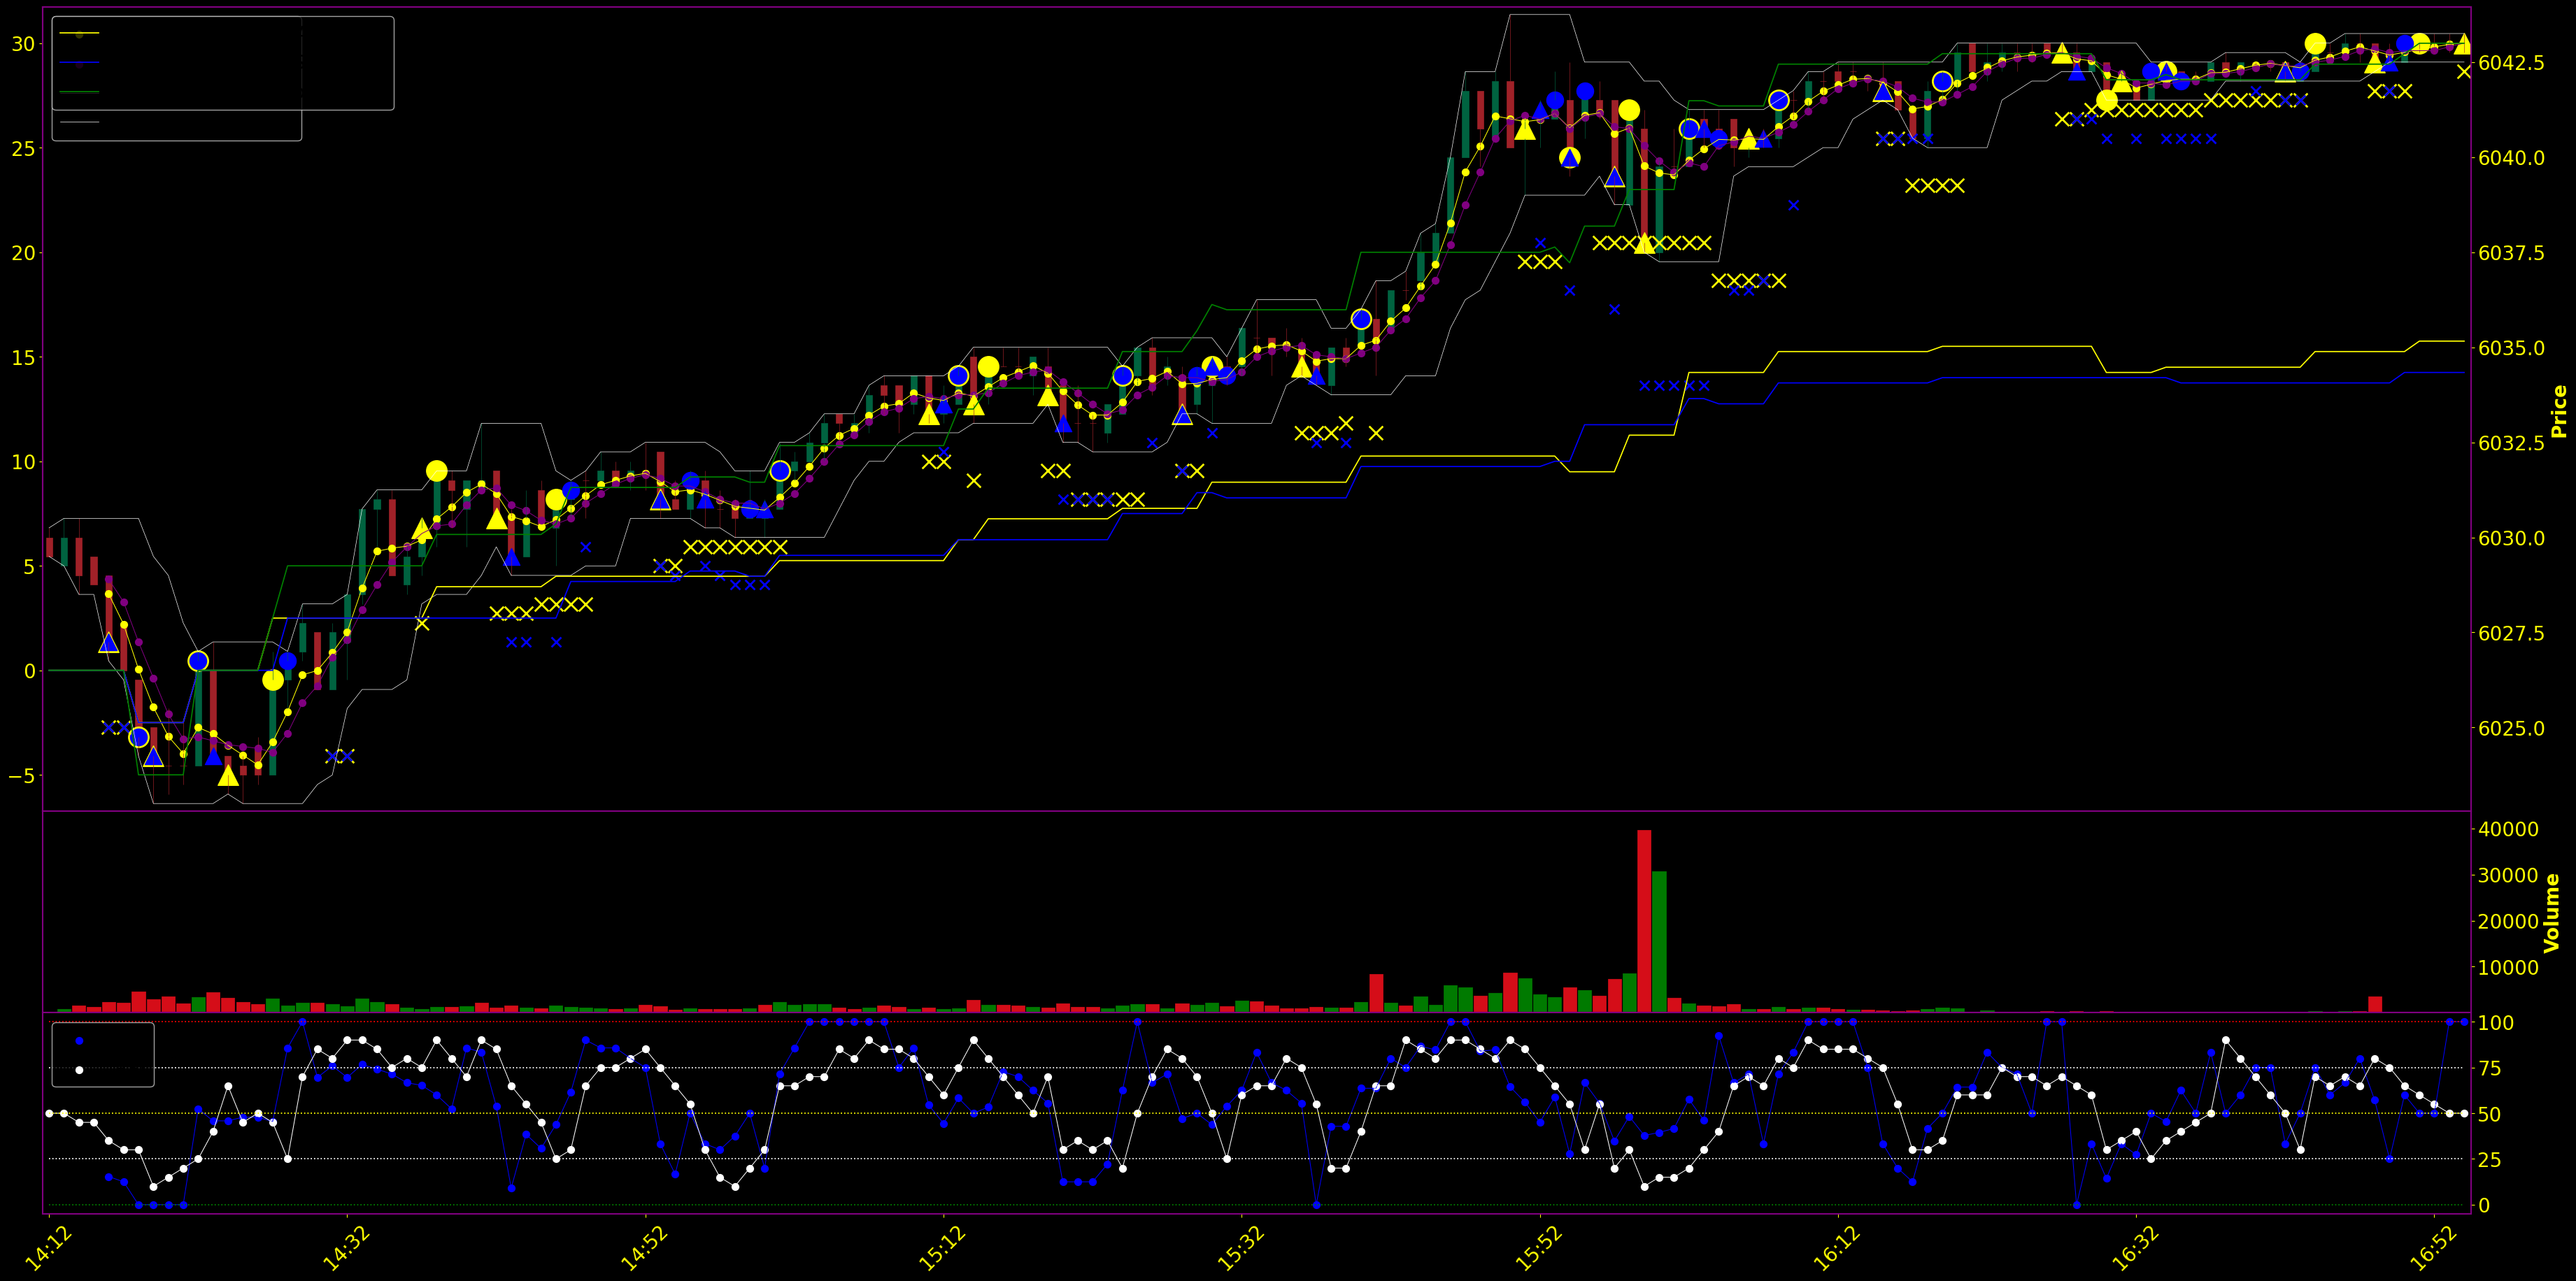

/ES : 164 minutes : 21 ma trades : 22 rsi trades : 30.0 total pnl


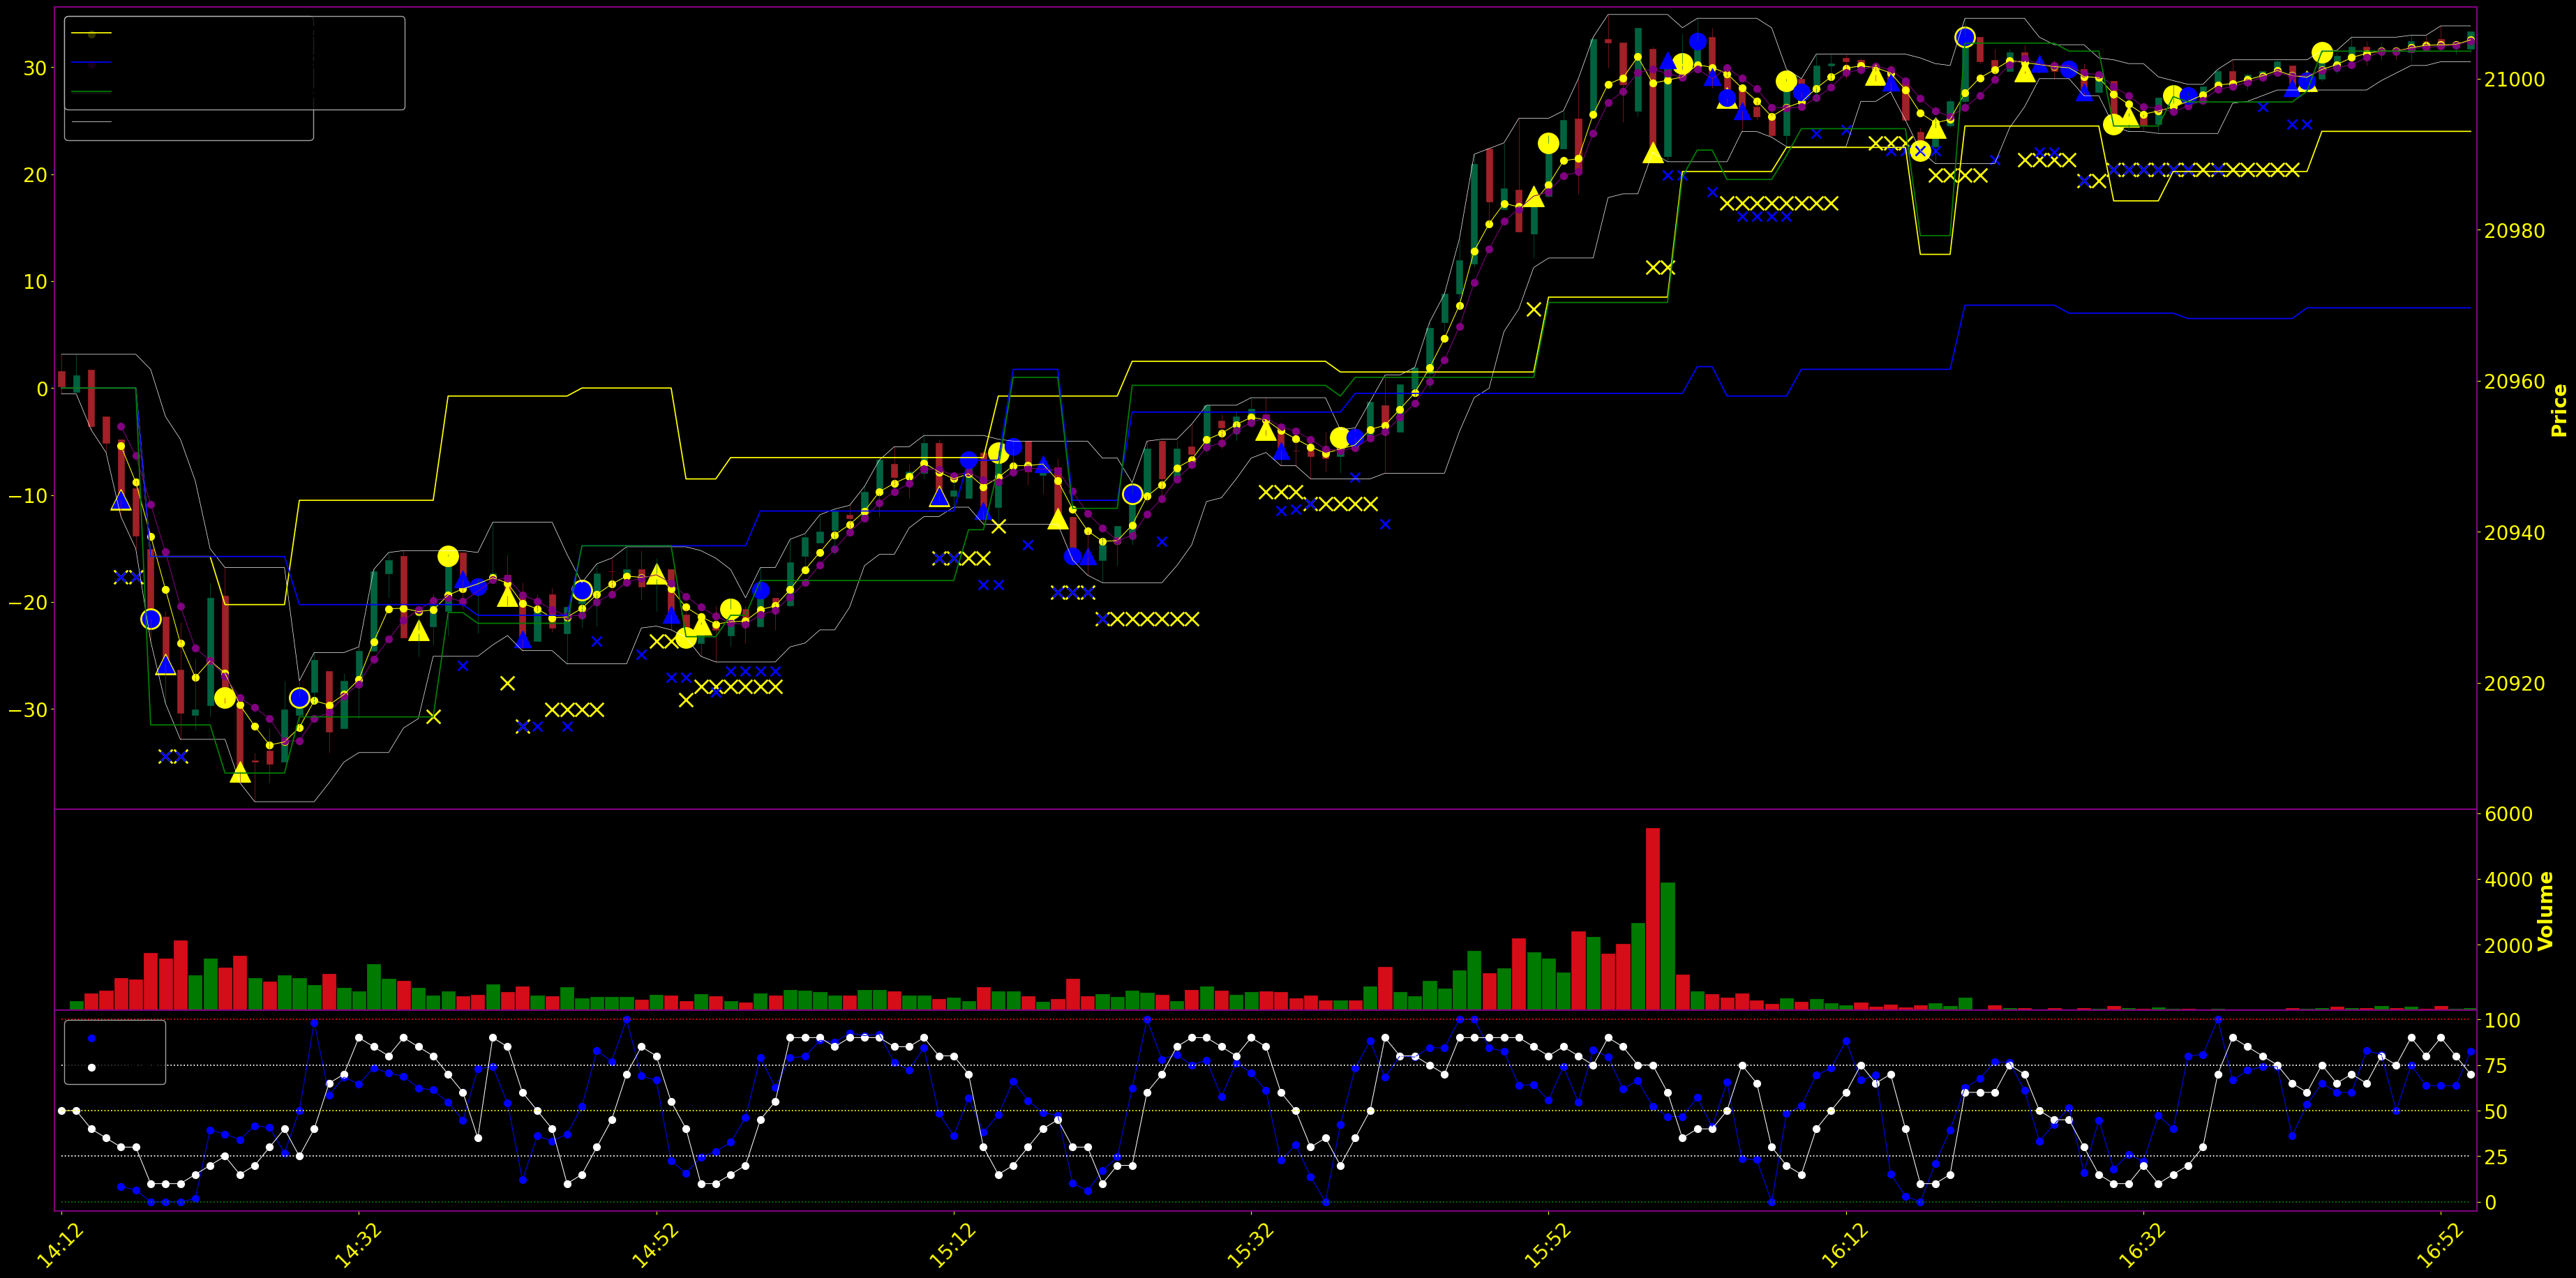

/NQ : 164 minutes : 18 ma trades : 17 rsi trades : 31.5 total pnl


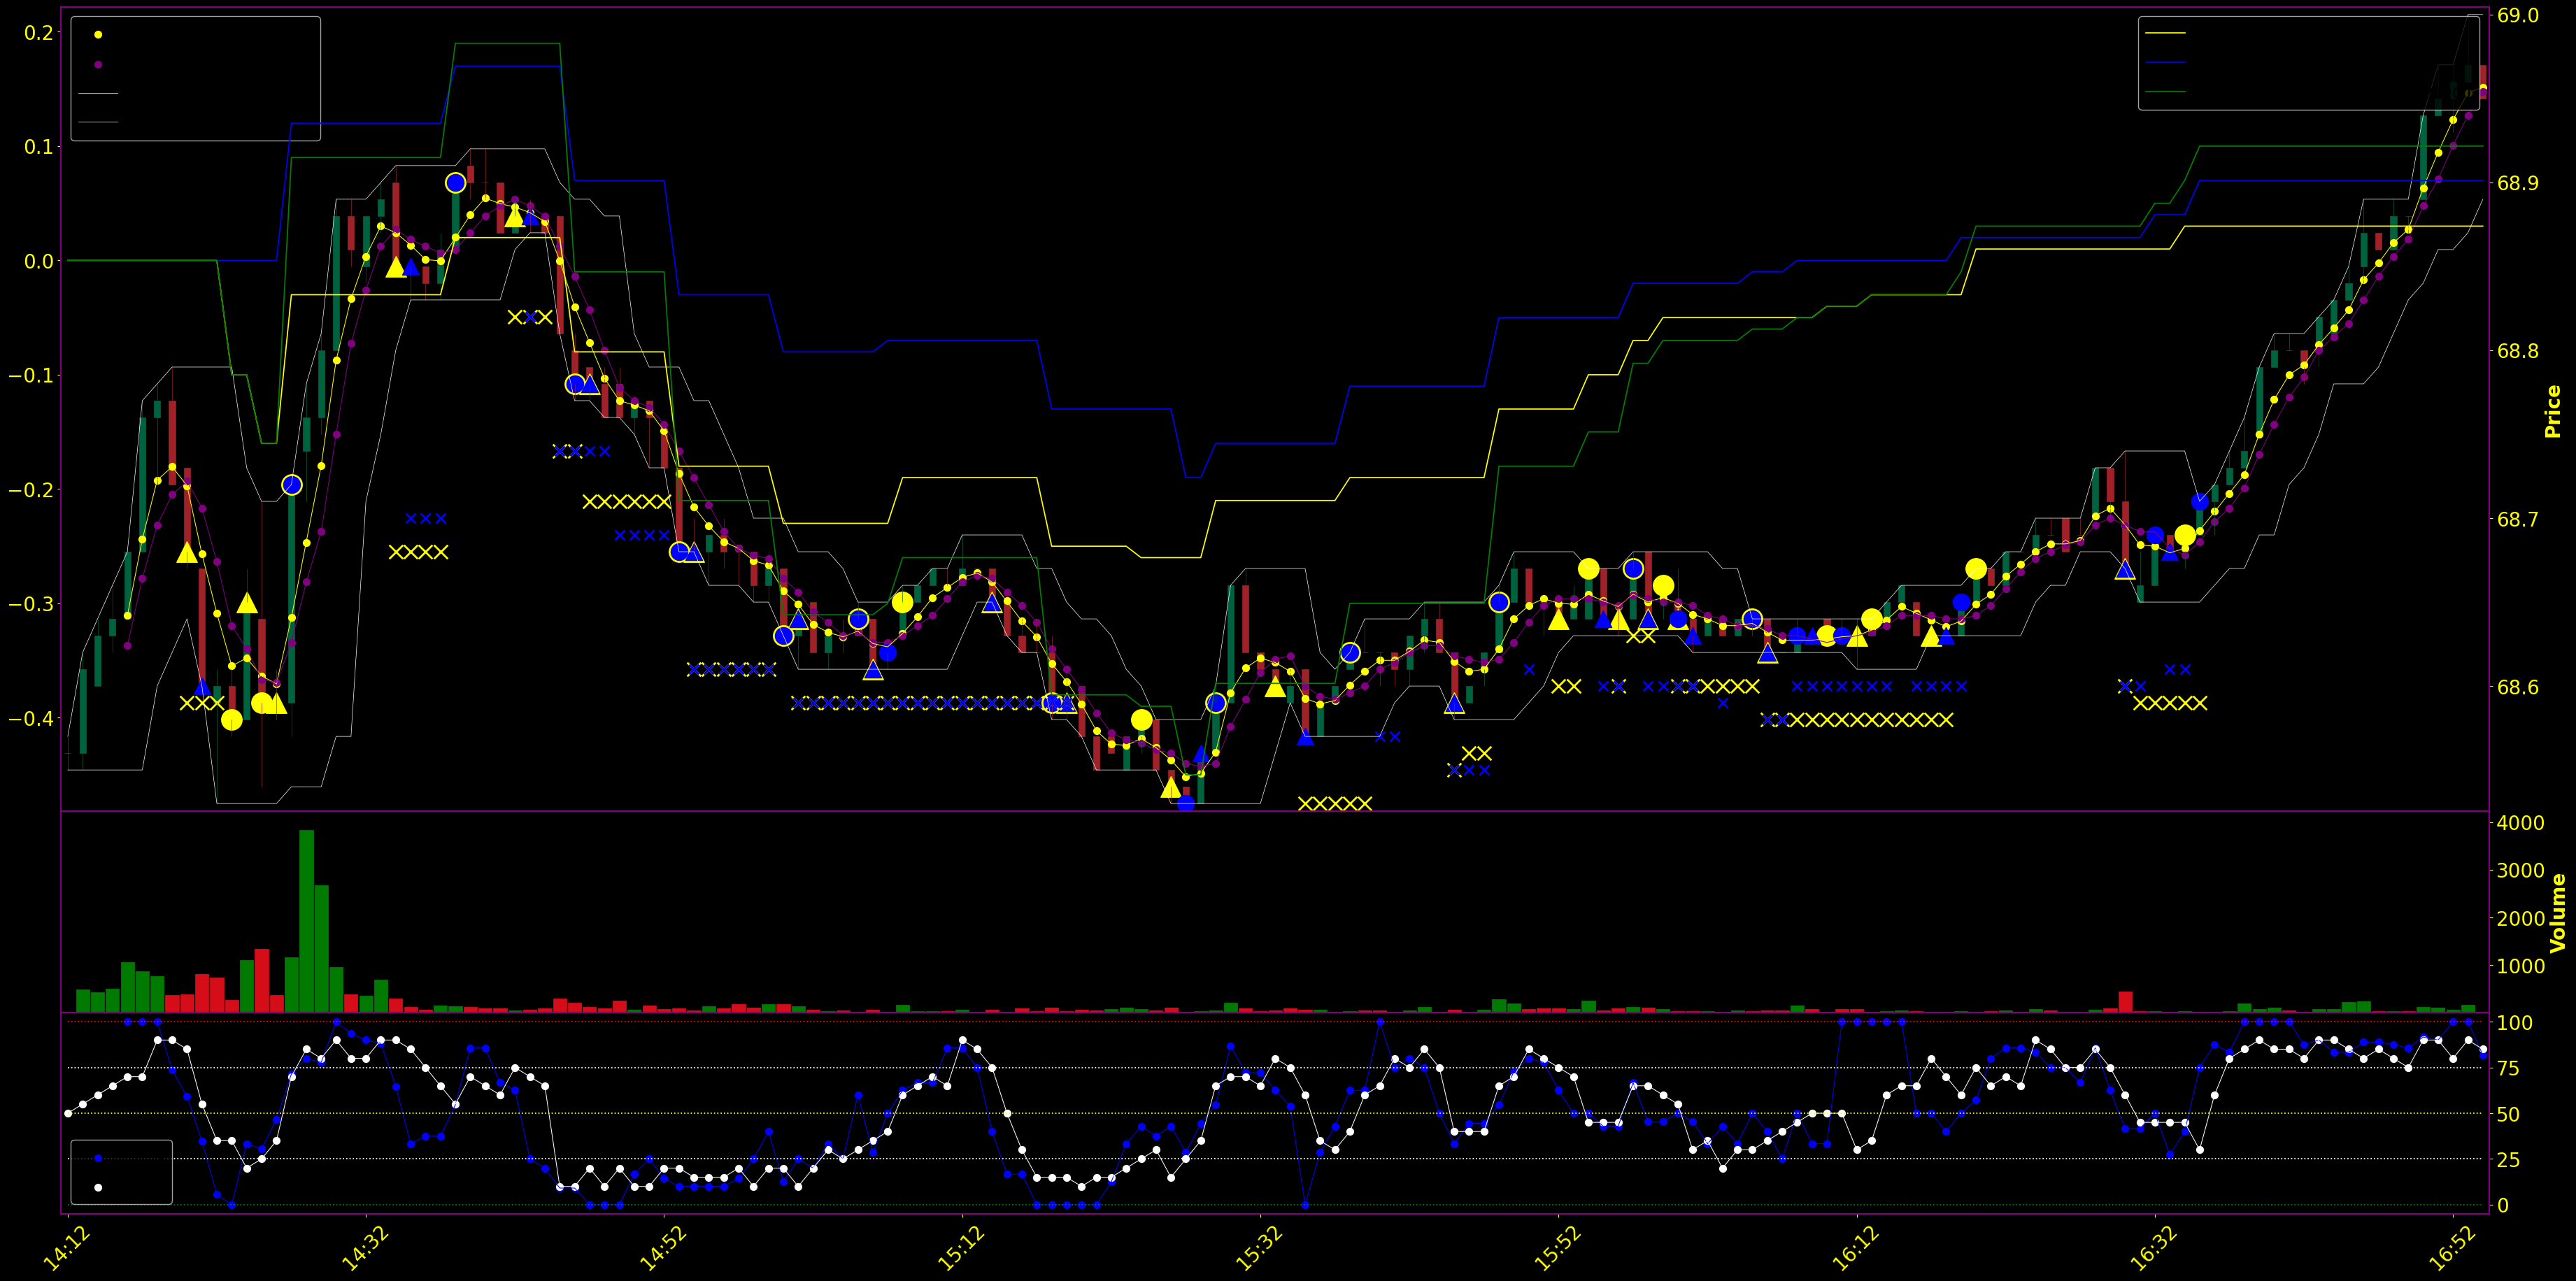

/CL : 164 minutes : 22 ma trades : 20 rsi trades : 0.10000000000002274 total pnl


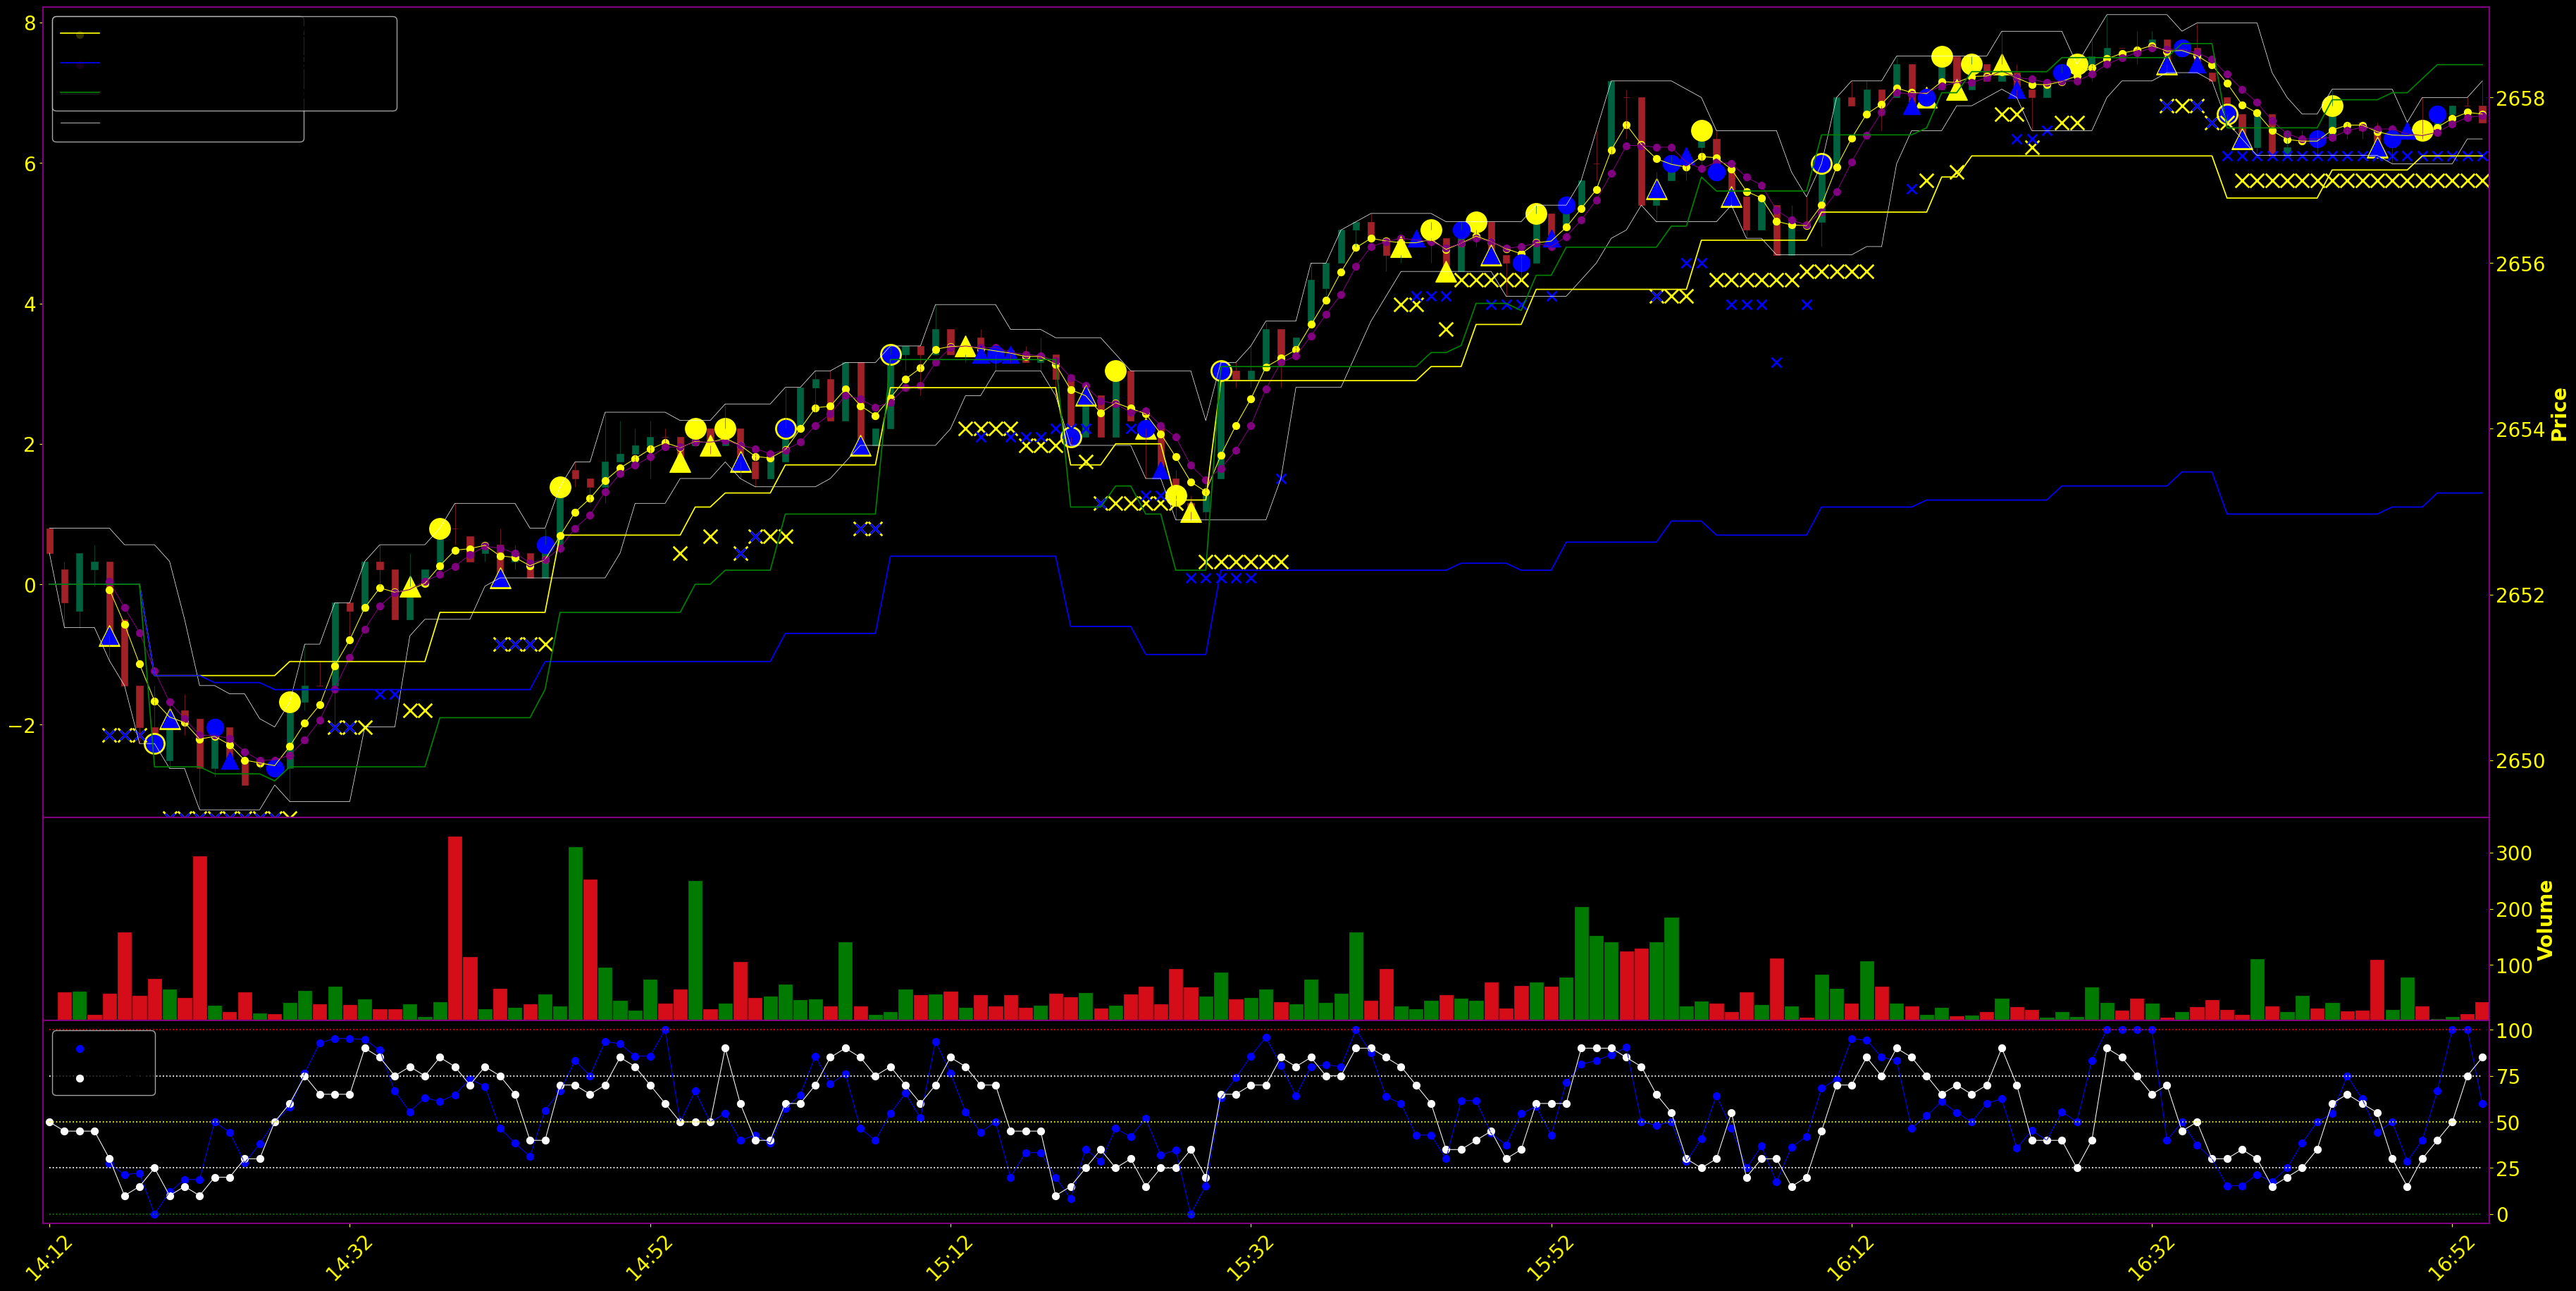

/GC : 164 minutes : 23 ma trades : 23 rsi trades : 7.399999999998272 total pnl


In [52]:
sig_ma = 'wma_5'
con_ma = 'sma_5'
rsi_plt = 'rsi_5'
signal_ma='signal_wma_5_sma_5'
signal_rsi='signal_rsi_5'

visualize_trades(minute_candles, lower_slice=-200, upper_slice=-1)

In [53]:
def print_all_pnls(candles):
    for ticker, minute_candles_df in candles.items():
        total_pnl = round(minute_candles_df["cum_pnl_all"].iloc[-1], 3)
        close_price_diff = round(minute_candles_df["close"].iloc[-1] - minute_candles_df["close"].iloc[0], 3)
        point_alpha = round(total_pnl - close_price_diff, 3)
        print(f'{ticker} : {total_pnl} total pnl, Close Price Difference: {close_price_diff}, Point Alpha: {point_alpha}')

# Call print_all_pnls() to print all profit figures and close price differences
print_all_pnls(minute_candles)

/ES : 30.0 total pnl, Close Price Difference: 13.5, Point Alpha: 16.5
/NQ : 31.5 total pnl, Close Price Difference: 46.75, Point Alpha: -15.25
/CL : 0.1 total pnl, Close Price Difference: 0.39, Point Alpha: -0.29
/GC : 7.4 total pnl, Close Price Difference: 5.4, Point Alpha: 2.0


### Yet another branch, all mashed together. Pulling stop loss functionality from the rest of things.

In [ ]:
def check_moving_average(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
    """
    Generate buy/sell signals based on moving averages and RSI indicators.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.

    Returns:
    - candles (pd.DataFrame): The DataFrame with updated signal columns.
    """
    # Initialize signal columns
    candles[f'signal_{ma_name1}_{ma_name2}'] = 0
    candles[f'signal_{rsi_column}'] = 0

    ma_position_open = False
    rsi_position_open = False

    for i, row in candles.iterrows():
        # Moving Average Signal Generation
        if i == 0:  # First row, no previous row to compare
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0
        elif not ma_position_open and row[ma_name1] <= row[ma_name2]:
            ma_position_open = True
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 1
        elif ma_position_open and row[ma_name1] > row[ma_name2]:
            ma_position_open = False
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0
        else:
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = candles.at[i - 1, f'signal_{ma_name1}_{ma_name2}']

        # RSI Signal Generation
        if i == 0:  # First row, no previous row to compare
            candles.at[i, f'signal_{rsi_column}'] = 0
        elif not rsi_position_open and row[rsi_column] < 50:
            rsi_position_open = True
            candles.at[i, f'signal_{rsi_column}'] = 1
        elif rsi_position_open and row[rsi_column] >= 50:
            rsi_position_open = False
            candles.at[i, f'signal_{rsi_column}'] = 0
        else:
            candles.at[i, f'signal_{rsi_column}'] = candles.at[i - 1, f'signal_{rsi_column}']

    return candles

# Now visualize the entry and exit prices instead of the markers, take away the repetition, and calculate profit on exit and entry prices !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# calculate_profit_loss function needs to be modified to calculate profit based on entry and exit prices !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def apply_stop_loss(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', ticker=None, ticker_to_tick_size=None):
    """
    Apply stop loss logic based on MA and RSI signals, and update entry and exit price columns.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - ticker (str): Ticker symbol for the instrument.
    - ticker_to_tick_size (dict): Dictionary mapping tickers to tick sizes.

    Returns:
    - candles (pd.DataFrame): The DataFrame with updated stop loss and price columns.
    """
    # Initialize required columns
    candles['stop_loss_ma'] = None
    candles['stop_loss_rsi'] = None
    candles['ma_entry_price'] = None
    candles['ma_exit_price'] = None
    candles['rsi_entry_price'] = None
    candles['rsi_exit_price'] = None

    # Get tick size for the ticker
    tick_size = ticker_to_tick_size.get(ticker, 0) if ticker_to_tick_size else 0

    # Variables to track entry and exit prices
    ma_entry_price = None
    rsi_entry_price = None

    for i, row in candles.iterrows():
        # Moving Average Stop Loss and Entry/Exit Prices
        if row[f'signal_{ma_name1}_{ma_name2}'] == 1:
            if ma_entry_price is None:  # Entry point
                ma_entry_price = row['close'] + tick_size  # Adjust for bid-ask spread
            candles.at[i, 'stop_loss_ma'] = ma_entry_price - row['candle_span_max']
            candles.at[i, 'ma_entry_price'] = ma_entry_price
        elif row[f'signal_{ma_name1}_{ma_name2}'] == 0 and ma_entry_price is not None:
            # Exit point
            ma_exit_price = row['close'] - tick_size  # Adjust for bid-ask spread
            candles.at[i, 'ma_exit_price'] = ma_exit_price
            ma_entry_price = None  # Reset entry price
            candles.at[i, 'stop_loss_ma'] = None

        # RSI Stop Loss and Entry/Exit Prices
        if row[f'signal_{rsi_column}'] == 1:
            if rsi_entry_price is None:  # Entry point
                rsi_entry_price = row['close'] + tick_size  # Adjust for bid-ask spread
            candles.at[i, 'stop_loss_rsi'] = rsi_entry_price - row['candle_span_max']
            candles.at[i, 'rsi_entry_price'] = rsi_entry_price
        elif row[f'signal_{rsi_column}'] == 0 and rsi_entry_price is not None:
            # Exit point
            rsi_exit_price = row['close'] - tick_size  # Adjust for bid-ask spread
            candles.at[i, 'rsi_exit_price'] = rsi_exit_price
            rsi_entry_price = None  # Reset entry price
            candles.at[i, 'stop_loss_rsi'] = None

    return candles

def calculate_profit_loss(candles, signal_ma='signal_wma_5_sma_5', signal_rsi='signal_rsi_5', multiplier=1):
    """
    Calculate profit and loss based on signals.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data and signal columns.

    Returns:
    - candles (pd.DataFrame): The DataFrame with profit/loss columns.
    """
    candles['pnl_ma'] = None
    candles['pnl_rsi'] = None

    ma_position_open = False
    rsi_position_open = False

    ma_buy_price = None
    rsi_buy_price = None

    for i, row in candles.iterrows():
        # Moving Average PnL
        if row[signal_ma] == 1 and not ma_position_open:
            ma_buy_price = row['close']
            ma_position_open = True
            candles.at[i, 'pnl_ma'] = 0
        elif row[signal_ma] == 0 and ma_position_open:
            ma_sell_price = row['close']
            ma_position_open = False
            candles.at[i, 'pnl_ma'] = (ma_sell_price - ma_buy_price) * multiplier

        # RSI PnL
        if row[signal_rsi] == 1 and not rsi_position_open:
            rsi_buy_price = row['close']
            rsi_position_open = True
            candles.at[i, 'pnl_rsi'] = 0
        elif row[signal_rsi] == 0 and rsi_position_open:
            rsi_sell_price = row['close']
            rsi_position_open = False
            candles.at[i, 'pnl_rsi'] = (rsi_sell_price - rsi_buy_price) * multiplier

    # Replace NaN values with 0 and calculate cumulative PnL
    candles['pnl_ma'].fillna(0, inplace=True)
    candles['pnl_rsi'].fillna(0, inplace=True)
    candles['cum_pnl_ma'] = candles['pnl_ma'].cumsum()
    candles['cum_pnl_rsi'] = candles['pnl_rsi'].cumsum()
    candles['cum_pnl_all'] = candles['cum_pnl_ma'] + candles['cum_pnl_rsi']

    # Add buy, sell, and neutral markers if signal_column exists
    if signal_ma:
        candles = add_signal_markers_long_only(candles, 
                                            signal_ma, 
                                            price_col='close')
    else:
        print('signal_ma must be missing')

    if signal_rsi:
        candles = add_signal_markers_long_only(candles, 
                                            signal_rsi, 
                                            price_col='close', 
                                            buy_marker='buy_marker_2', 
                                            #    sell_marker='sell_marker_2', 
                                            neutral_marker='neutral_marker_2')
    else:
        print('signal_rsi must be missing')

    return candles

def filter_columns_in_dict(df_dict, columns_to_keep):
    """
    Remove all columns except the specified ones from each DataFrame in a dictionary,
    and reset the index of each filtered DataFrame.
    
    Parameters:
    - df_dict (dict): A dictionary where keys are DataFrame names and values are DataFrames.
    - columns_to_keep (list): List of columns to keep in each DataFrame.
    
    Returns:
    - dict: The updated dictionary with filtered DataFrames.
    """
    for key, df in df_dict.items():
        # Keep only the specified columns
        df_filtered = df[columns_to_keep].copy()
        # Reset the index
        df_dict[key] = df_filtered.reset_index(drop=True)
        print(f"Filtered columns for {key}. Remaining columns: {df_dict[key].columns.tolist()}")
    return df_dict

In [ ]:
# Specify the columns to keep
columns_to_save = ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']

# Apply the function to the minute_candles dictionary
minute_candles = filter_columns_in_dict(minute_candles, columns_to_save)

# Define the periods for SMAs and WMAs
ma_periods=[5, 10, 20]
sma_periods = ma_periods
wma_periods = ma_periods
rsi_periods = ma_periods

# Define the list of (sig_ma, con_ma, rsi_col) combinations
ma_combinations = [
    ('wma_5', 'sma_5', 'rsi_5'),
    ('wma_10', 'sma_10', 'rsi_10'),
    ('wma_20', 'sma_20', 'rsi_20')
]

# Iterate through all the tickers in ticker_tables
for ticker, df in minute_candles.items():
    # Calculate moving averages and indicators for each DataFrame
    minute_candles[ticker] = calculate_indicators(
        df, 
        price_col='close', 
        acc_vol_col='accumulative_volume', 
        sma_periods=sma_periods,
        wma_periods=wma_periods,
        rsi_periods=rsi_periods,
        candle_window=5
    )

for ticker, df in minute_candles.items():
    # Iterate over the (sig_ma, con_ma, rsi_col) combinations for each ticker
    for sig_ma, con_ma, rsi_col in ma_combinations:                                    # CHANGE THE SIMULATED STRATEGY HERE
        # Call the check_moving_average function for each combination
        check_moving_average(df,
                            # ticker=ticker, # comment this out if not needed or causing problems
                            # ticker_to_tick_size=ticker_to_tick_size, # comment this out if not needed or causing problems
                            ma_name1=sig_ma, 
                            ma_name2=con_ma, 
                            rsi_column=rsi_col
                            ) # CHANGE THE SIMULATED STRATEGY HERE
        
for ticker, df in minute_candles.items():
    # Apply stop loss logic with entry/exit prices
    minute_candles[ticker] = apply_stop_loss(
        df,
        ma_name1='wma_5',
        ma_name2='sma_5',
        rsi_column='rsi_5',
        ticker=ticker,
        ticker_to_tick_size=ticker_to_tick_size
    )

# Calculate profit/loss for each ticker's DataFrame
for ticker, df in minute_candles.items():                                                                                       # CHANGE THE SIMULATED STRATEGY HERE
    minute_candles[ticker] = calculate_profit_loss(df, signal_ma='signal_wma_5_sma_5', signal_rsi='signal_rsi_5', multiplier=1) # CHANGE THE SIMULATED STRATEGY HERE

In [ ]:
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.options.display.float_format = '{:,.4f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
# pd.reset_option('display.max_rows') # Display default abbreviated rows

key = 0

tickers_list = list(ticker_tables.keys())
# display(minute_candles)
display(tickers_list)
# display(ticker_tables[tickers_list[key]])
# display(minute_candles[tickers_list[key]])
display(minute_candles[tickers_list[key]][['close', 
                                           'candle_span_max', 
                                           'stop_loss_ma', 
                                           'wma_5', 'sma_5', 
                                           'signal_wma_5_sma_5', 
                                           'buy_marker',
                                           'ma_entry_price', 
                                        #    'sell_marker', 
                                           'neutral_marker',
                                           'ma_exit_price',
                                           'close', 
                                           'candle_span_max', 
                                           'stop_loss_rsi', 
                                           'rsi_5', 
                                           'signal_rsi_5', 
                                           'buy_marker_2', 
                                           'rsi_entry_price',
                                        #    'sell_marker_2', 
                                           'neutral_marker_2',
                                           'rsi_exit_price']])

Visualize the streamed and stored data

In [ ]:
sig_ma = 'wma_5'
con_ma = 'sma_5'
rsi_plt = 'rsi_5'
signal_ma='signal_wma_5_sma_5'
signal_rsi='signal_rsi_5'

visualize_trades(minute_candles, lower_slice=-200, upper_slice=-1)

# # Initialize a variable to hold the task reference
# visualization_task = None  # This ensures visualization_task is defined

# async def update_visualization():
#     while True:
#         # Clear the previous output
#         clear_output(wait=True)
       
#         # Call the visualization function
#         visualize_trades(lower_slice=0, upper_slice=-1)
        
#         # Wait for 5 seconds before repeating
#         await asyncio.sleep(60)

# def start_visualization():
#     global visualization_task
#     # Start the update_visualization function if it's not already running
#     if visualization_task is None:
#         loop = asyncio.get_event_loop()
#         visualization_task = loop.create_task(update_visualization())

# def stop_visualization():
#     global visualization_task
#     # Stop the update_visualization function if it's running
#     if visualization_task is not None:
#         visualization_task.cancel()  # Cancel the task
#         visualization_task = None

# # Start the visualization
# start_visualization()

# Thoughts on what can be done to address issues in the strategy, specifically the switch from one mode to another: 
 # Could use ma points themselves to determine when to switch from one mode to another- if over a the same period, points tend to stay in consistent position from one another, trend mode
 # If it changes a lot within the period, mean reversion mode
 # Put into words what is going wrong here: stop losses- only create a stop loss when a trade is opened, eliminate it when we are market neutral
 # Create a dictionary of ticker to point value for use in printing point value under each chart
 # create an indicator made from the highs and lows of the candles directly instead of using the envelope
 # Things that are going wrong: 
 # - MA stop losses are inconsistent with entries. Fix it

Add metrics for difference between last and first close price, and difference between that and total pnl, and a boolean to determine whether the algorithm had alpha (better performance than buy/hold)

In [ ]:
def print_all_pnls(candles):
    for ticker, minute_candles_df in candles.items():
        total_pnl = round(minute_candles_df["cum_pnl_all"].iloc[-1], 3)
        close_price_diff = round(minute_candles_df["close"].iloc[-1] - minute_candles_df["close"].iloc[0], 3)
        point_alpha = round(total_pnl - close_price_diff, 3)
        print(f'{ticker} : {total_pnl} total pnl, Close Price Difference: {close_price_diff}, Point Alpha: {point_alpha}')

# Call print_all_pnls() to print all profit figures and close price differences
print_all_pnls(minute_candles)

In [ ]:
# check_moving_average cell 1: loses big when the market dumps
# /ES : 632 minutes : 65 ma trades : 59 rsi trades : -90.5 total pnl
# /NQ : 632 minutes : 61 ma trades : 63 rsi trades : -310.5 total pnl
# /CL : 632 minutes : 69 ma trades : 73 rsi trades : 1.640000000000029 total pnl
# /GC : 632 minutes : 64 ma trades : 61 rsi trades : -29.999999999996817 total pnl

# check_moving_average cell 2: Loses less money when stop losses are in place. Possibly also gains less when it wins
# /ES : 632 minutes : 65 ma trades : 88 rsi trades : -57.5 total pnl
# /NQ : 632 minutes : 61 ma trades : 91 rsi trades : -246.75 total pnl
# /CL : 632 minutes : 69 ma trades : 96 rsi trades : 1.2900000000000773 total pnl
# /GC : 632 minutes : 64 ma trades : 90 rsi trades : -8.699999999997544 total pnl

# check_moving_average cell 3: performs worse than cell 2. Find out what the difference is
# /ES : 632 minutes : 101 ma trades : 97 rsi trades : -80.5 total pnl
# /NQ : 632 minutes : 88 ma trades : 93 rsi trades : -277.0 total pnl
# /CL : 632 minutes : 98 ma trades : 112 rsi trades : 1.1000000000000512 total pnl
# /GC : 632 minutes : 96 ma trades : 103 rsi trades : -21.499999999995907 total pnl

# check_moving_average cell 4: performs better than cell 3. Find out what the difference is
# /ES : 632 minutes : 138 ma trades : 91 rsi trades : -44.75 total pnl
# /NQ : 632 minutes : 123 ma trades : 82 rsi trades : -106.75 total pnl
# /CL : 632 minutes : 141 ma trades : 116 rsi trades : 0.9400000000000261 total pnl
# /GC : 632 minutes : 131 ma trades : 94 rsi trades : -16.999999999998636 total pnl

# /ES : 11.5 total pnl
# /NQ : 49.5 total pnl
# /CL : -0.08999999999997499 total pnl
# /GC : 3.900000000000091 total pnl

# Non-Market Hours Research

In [ ]:
def load_dfs_from_csv(load_path="dataframes/", columns_to_load=None):
    """
    Load CSV files from a directory into a dictionary of DataFrames, 
    ensuring correct data types for specified columns.
    
    Parameters:
    - load_path (str): The directory from which the CSV files will be loaded.
    - columns_to_load (list): A list of columns to load from each CSV file. Default is None (load all columns).

    Returns:
    - dict: A dictionary where keys are file names (prefixed with '/') and values are DataFrames.
    """
    candles = {}
    
    # Define column data types
    dtype_conversion = {
        'open': 'float64',
        'high': 'float64',
        'low': 'float64',
        'close': 'float64',
        'accumulative_volume': 'float64'
    }

    # Load each CSV file
    for file_name in os.listdir(load_path):
        if file_name.endswith('.csv'):  # Only process CSV files
            df_name = '/' + file_name.replace('.csv', '')  # Add '/' to the name
            file_path = os.path.join(load_path, file_name)
            
            try:
                # Load the DataFrame with specified columns
                df = pd.read_csv(file_path, usecols=columns_to_load, parse_dates=['datetime'], on_bad_lines='skip')

                # Ensure correct data types for numeric columns
                for col, dtype in dtype_conversion.items():
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')

                # Filter out rows where 'close' is 0, NaN, or None
                if 'close' in df.columns:
                    df = df[(df['close'] != 0) & df['close'].notna()]

                # Reset index for a numerical index
                df.reset_index(drop=True, inplace=True)
                
                candles[df_name] = df  # Add DataFrame to the dictionary
                print(f"Loaded: {file_path}")
            
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
    
    return candles

columns_to_load = ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']
minute_candles_nmhr = load_dfs_from_csv(load_path="dataframes/", columns_to_load=columns_to_load)

In [ ]:
def check_column_data_types(df_dict):
    """
    Check and display the data types of all columns for each DataFrame in the dictionary.

    Parameters:
    - df_dict (dict): A dictionary where keys are names and values are DataFrames.

    Returns:
    - dict: A dictionary with DataFrame names as keys and column data types as values.
    """
    data_types = {}
    
    for key, df in df_dict.items():
        if not df.empty:
            # Store the column data types for each DataFrame
            data_types[key] = df.dtypes.to_dict()
            print(f"\nData types for {key}:")
            print(df.dtypes)
        else:
            print(f"\n{key} is empty.")
            data_types[key] = None

    return data_types

# Example usage:
data_types = check_column_data_types(minute_candles_nmhr)

In [ ]:
tickers = "/ES,/NQ,/CL,/GC"
tickers_list = list(minute_candles_nmhr.keys())

key = 1

display(minute_candles_nmhr)
for key in range(len(tickers_list)):
    display(minute_candles_nmhr[tickers_list[key]])

In [ ]:
minute_candles_nmhr['/NQ'][4900:4910]

In [ ]:
import pandas as pd

def get_shared_unique_dates(candles, string_format=False):
    """
    Returns a list of unique dates shared across all DataFrames in a dictionary.

    Args:
        candles (dict): A dictionary where keys are tickers and values are DataFrames containing a 'datetime' column.

    Returns:
        list: A list of unique dates (YYYY-MM-DD) shared by all DataFrames in the dictionary.
    """
    # Initialize a set to hold shared dates
    shared_dates = None

    for df in candles.values():
        # Ensure 'datetime' column is a datetime type
        df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert(None)

        # Extract unique dates from the current DataFrame
        unique_dates = set(df['datetime'].dt.date)

        # Update shared dates
        if shared_dates is None:
            shared_dates = unique_dates  # Initialize with the first DataFrame's dates
        else:
            shared_dates &= unique_dates  # Intersect with subsequent DataFrame dates

    # Convert shared dates set to a sorted list
    if string_format:
        return sorted(date.isoformat() for date in shared_dates)
    else:
        return sorted(shared_dates)

shared_dates = get_shared_unique_dates(minute_candles_nmhr, string_format=True)
shared_dates

In [ ]:
tickers = "/ES,/NQ,/CL,/GC"
tickers_list = list(minute_candles_nmhr.keys())

key = 1

display(minute_candles_nmhr)
for key in range(len(tickers_list)):
    display(minute_candles_nmhr[tickers_list[key]])

### Use the copy of minute_candles if it still exists in the environment

In [ ]:
minute_candles_nmhr = minute_candles.copy() # Wrap this in an if else statement so that this only happens if minute_candles_nmhr is not already defined

In [ ]:
def check_moving_average_nmhr(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'): # , signal_column='signal_wma_5_sma_5', signal_column_2='signal_rsi_5'
    """ An attempt at implementing ma_stop_loss_hit logic into the function. produces some whacky results. Possibly a dated model if the new one works better.
    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): The column name for the first moving average (default is 'wma_5').
    - ma_name2 (str): The column name for the second moving average (default is 'sma_5').
    - rsi_column (str): The column name for the RSI indicator (default is 'rsi_5').
    
    Returns:
    - candles (pd.DataFrame): The DataFrame with updated 'signal' and stop loss values.
    """
    current_time_USE = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S')

    ma_position_open = False  # Initialize the MA position to neutral
    ma_entry_price = None     # Initialize the MA entry price to None
    ma_stop_loss_hit = False  # Track if a stop loss has been hit

    rsi_position_open = False # Initialize the RSI position to neutral
    rsi_entry_price = None    # Initialize the RSI entry price to None

    # Iterate through each row in the candles DataFrame
    for i, row in candles.iterrows():

        # # Moving Average Strategy
        if ma_stop_loss_hit: # This is the wonky one with reverse logic. Behaves strangely with respect to stop losses and entries/exits
            # If stop loss was hit, stay neutral as long as ma_name1 remains below ma_name2
            if row[ma_name1] < row[ma_name2]:
                ma_stop_loss_hit = True  # Reset stop loss hit state
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # Stay market neutral
            candles.at[i, 'stop_loss_ma'] = None  # No active stop loss
            continue

        # if pd.notna(row[ma_name1]) and pd.notna(row[ma_name2]): # Uncomment this line and indent the following chunk to undo fuckery                # If neither MA column is all null, then proceed
        if not ma_position_open and row[ma_name1] <= row[ma_name2]:                                 # If no position is open and wma is below or equal to sma
            ma_position_open = True                                                                 # Set the MA position to open
            ma_entry_price = row['close']                                                           # Record the entry price for use in determining stop loss
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 1                                      # Set the MA signal column to long (1)
            candles.at[i, 'stop_loss_ma'] = (ma_entry_price - row['candle_span_max'])       # Set the stop loss level
        elif ma_position_open and row['close'] < (ma_entry_price - row['candle_span_max']): # If the price drops below the stop loss level
            ma_position_open = False                                                                # Set the MA position to neutral
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0                                      # Set the MA signal column to neutral (0)
            candles.at[i, 'stop_loss_ma'] = None                                                    # Reset stop loss after it's triggered
        elif ma_position_open and row[ma_name1] > row[ma_name2]:                                    # If a position is open and wma is above sma
            ma_position_open = False                                                                # Set the MA position to neutral
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0                                      # Set the MA signal column to neutral (0)
            candles.at[i, 'stop_loss_ma'] = None                                                    # Reset stop loss after closing the position due to MA crossover opposite day
        elif ma_position_open:                                                                      # If a position is still open past the closing conditions
            candles.at[i, 'stop_loss_ma'] = candles.at[i-1, 'stop_loss_ma']                         # Retain the stop loss value for risk management and visualization

        # # RSI Strategy
        # if pd.notna(row[rsi_column]): # Uncomment this line and indent the following chunk to undo fuckery                                                               # If the RSI column is not all null, then proceed
        if not rsi_position_open and row[rsi_column] < 50:                                          # If no position is open and RSI is below 50
            rsi_position_open = True                                                                # Set the RSI position to open
            rsi_entry_price = row['close']                                                          # Record the entry price for use in determining stop loss
            candles.at[i, f'signal_{rsi_column}'] = 1                                               # Set the RSI signal column to long (1)
            candles.at[i, 'stop_loss_rsi'] = rsi_entry_price - row['candle_span_max']       # Set the stop loss level
        elif rsi_position_open and row['close'] < rsi_entry_price - row['candle_span_max']: # If a position is open and the price drops below the stop loss level
            rsi_position_open = False                                                               # Set the RSI position to neutral
            candles.at[i, f'signal_{rsi_column}'] = 0                                               # Set the RSI signal column to neutral (0)
            candles.at[i, 'stop_loss_rsi'] = None                                                   # Reset stop loss after it's triggered
        elif rsi_position_open and row[rsi_column] >= 50:                                           # If a position is open and RSI is above or equal to 50
            rsi_position_open = False                                                               # Set the RSI position to neutral
            candles.at[i, f'signal_{rsi_column}'] = 0                                               # Set the RSI signal column to neutral (0)
            candles.at[i, 'stop_loss_rsi'] = None                                                   # Reset stop loss after closing the position due to RSI crossover opposite day
        elif rsi_position_open:                                                                     # If a position is still open past the closing conditions
            candles.at[i, 'stop_loss_rsi'] = candles.at[i-1, 'stop_loss_rsi']                       # Retain the stop loss value for risk management and visualization

    return candles

Something is wrong with this function to where buy markers aren't being counted when plotting

In [ ]:
def check_moving_average_nmhr(candles, ma_name1='wma_5', ma_name2='sma_5'):
    """
    Implements the trading algorithm with stop loss logic taking precedence.!!!!!!!!!!!!!!!!!

    Args:
        candles (pd.DataFrame): The input DataFrame with columns for prices, moving averages, and other necessary data.
        ma_name1 (str): The name of the first moving average column (e.g., 'wma_5').
        ma_name2 (str): The name of the second moving average column (e.g., 'sma_5').

    Returns:
        pd.DataFrame: Updated DataFrame with trading signals and state columns.
    """
    # Initialize necessary columns
    candles[f'signal_{ma_name1}_{ma_name2}'] = 0  # Tracks the position: 1 for long, 0 for neutral
    candles['entry_price_ma'] = None  # Entry price of the position
    candles['stop_loss_ma'] = None  # Stop-loss level
    candles['stop_loss_active'] = False  # Tracks if stop-loss mode is active

    for i in range(1, len(candles)):
        # Get current and previous row for reference
        prev_row = candles.iloc[i - 1]
        curr_row = candles.iloc[i]

        # Stop Loss Logic: Overrides all other logic
        if prev_row[f'signal_{ma_name1}_{ma_name2}'] == 1:
            stop_loss = prev_row['stop_loss_ma']

            # Check if stop loss is hit
            if curr_row['close'] <= stop_loss:
                candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # Exit position
                candles.at[i, 'entry_price_ma'] = None
                candles.at[i, 'stop_loss_ma'] = None
                candles.at[i, 'stop_loss_active'] = True  # Activate stop-loss mode
                continue  # Skip other logic

        # Resume normal trading only after stop-loss mode is cleared
        if prev_row['stop_loss_active']:
            if curr_row[ma_name1] > curr_row[ma_name2]:  # Clear stop-loss mode when condition is met
                candles.at[i, 'stop_loss_active'] = False
            else:
                candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # Stay neutral
                continue  # Skip other logic

        # Normal Trading Logic
        if curr_row[ma_name1] <= curr_row[ma_name2] and prev_row[f'signal_{ma_name1}_{ma_name2}'] == 0:
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 1
            candles.at[i, 'entry_price_ma'] = curr_row['close']
            candles.at[i, 'stop_loss_ma'] = curr_row['close'] - curr_row['candle_span_max']

        elif prev_row[f'signal_{ma_name1}_{ma_name2}'] == 1:
            if curr_row[ma_name1] > curr_row[ma_name2]:
                candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0
                candles.at[i, 'entry_price_ma'] = None
                candles.at[i, 'stop_loss_ma'] = None

            else:  # Maintain position
                candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 1
                candles.at[i, 'entry_price_ma'] = prev_row['entry_price_ma']
                candles.at[i, 'stop_loss_ma'] = prev_row['stop_loss_ma']

        # Default: Copy signal forward if no new action
        if pd.isnull(candles.at[i, f'signal_{ma_name1}_{ma_name2}']):
            candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = prev_row[f'signal_{ma_name1}_{ma_name2}']

    # Ensure signal column is always 0 or 1
    candles[f'signal_{ma_name1}_{ma_name2}'] = candles[f'signal_{ma_name1}_{ma_name2}'].fillna(0).astype(int)
    return candles
    
def check_rsi_nmhr(candles, rsi_column='rsi_5'):
    """
    Implements the trading algorithm with configurable moving averages.

    Args:
        candles (pd.DataFrame): The input DataFrame with columns for prices, moving averages, and other necessary data.
        ma_name1 (str): The name of the first moving average column (e.g., 'wma_5').
        ma_name2 (str): The name of the second moving average column (e.g., 'sma_5').

    Returns:
        pd.DataFrame: Updated DataFrame with trading signals and state columns.
    """

    rsi_position_open = False # Initialize the RSI position to neutral
    rsi_entry_price = None    # Initialize the RSI entry price to None

    # Iterate through each row in the candles DataFrame
    for i, row in candles.iterrows():

        # # RSI Strategy
        # if pd.notna(row[rsi_column]): # Uncomment this line and indent the following chunk to undo fuckery                                                               # If the RSI column is not all null, then proceed
        if not rsi_position_open and row[rsi_column] < 50:                                          # If no position is open and RSI is below 50
            rsi_position_open = True                                                                # Set the RSI position to open
            rsi_entry_price = row['close']                                                          # Record the entry price for use in determining stop loss
            candles.at[i, f'signal_{rsi_column}'] = 1                                               # Set the RSI signal column to long (1)
            candles.at[i, 'stop_loss_rsi'] = rsi_entry_price - row['candle_span_max']       # Set the stop loss level
        elif rsi_position_open and row['close'] < rsi_entry_price - row['candle_span_max']: # If a position is open and the price drops below the stop loss level
            rsi_position_open = False                                                               # Set the RSI position to neutral
            candles.at[i, f'signal_{rsi_column}'] = 0                                               # Set the RSI signal column to neutral (0)
            candles.at[i, 'stop_loss_rsi'] = None                                                   # Reset stop loss after it's triggered
        elif rsi_position_open and row[rsi_column] >= 50:                                           # If a position is open and RSI is above or equal to 50
            rsi_position_open = False                                                               # Set the RSI position to neutral
            candles.at[i, f'signal_{rsi_column}'] = 0                                               # Set the RSI signal column to neutral (0)
            candles.at[i, 'stop_loss_rsi'] = None                                                   # Reset stop loss after closing the position due to RSI crossover opposite day
        elif rsi_position_open:                                                                     # If a position is still open past the closing conditions
            candles.at[i, 'stop_loss_rsi'] = candles.at[i-1, 'stop_loss_rsi']                       # Retain the stop loss value for risk management and visualization

    return candles

Redo all calculations after changing things up in the functions section.

In [ ]:
def filter_columns_in_dict(df_dict, columns_to_keep):
    """
    Remove all columns except the specified ones from each DataFrame in a dictionary,
    and reset the index of each filtered DataFrame.
    
    Parameters:
    - df_dict (dict): A dictionary where keys are DataFrame names and values are DataFrames.
    - columns_to_keep (list): List of columns to keep in each DataFrame.
    
    Returns:
    - dict: The updated dictionary with filtered DataFrames.
    """
    for key, df in df_dict.items():
        # Keep only the specified columns
        df_filtered = df[columns_to_keep].copy()
        # Reset the index
        df_dict[key] = df_filtered.reset_index(drop=True)
        print(f"Filtered columns for {key}. Remaining columns: {df_dict[key].columns.tolist()}")
    return df_dict

# Specify the columns to keep
columns_to_save = ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']

# Apply the function to the minute_candles dictionary
minute_candles_nmhr = filter_columns_in_dict(minute_candles_nmhr, columns_to_save)


In [ ]:
key = 0

tickers_list = list(ticker_tables.keys())
display(minute_candles_nmhr)
display(tickers_list)
display(ticker_tables[tickers_list[key]])
display(minute_candles_nmhr[tickers_list[key]])

Calculate indicators, signals/stop losses, and profit curves, then display the tables.

In [ ]:
ma_periods=[5, 10, 20]
sma_periods = ma_periods
wma_periods = ma_periods
rsi_periods = ma_periods

current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
current_second = datetime.now(pytz.timezone('US/Eastern')).second

# Define the list of (sig_ma, con_ma, rsi_col) combinations
ma_combinations = [
    ('wma_5', 'sma_5', 'rsi_5'),
    ('wma_10', 'sma_10', 'rsi_10'),
    ('wma_20', 'sma_20', 'rsi_20')
]

# Iterate through all the tickers in ticker_tables
for ticker, df in minute_candles_nmhr.items():
    # Calculate moving averages and indicators for each DataFrame
    minute_candles_nmhr[ticker] = calculate_indicators(
        df, 
        price_col='close', 
        acc_vol_col='accumulative_volume', 
        sma_periods=sma_periods,
        wma_periods=wma_periods,
        rsi_periods=rsi_periods
    )

# Iterate through all the tickers in minute_candles dictionary
for ticker, df in minute_candles_nmhr.items():
    # Iterate over the (sig_ma, con_ma, rsi_col) combinations for each ticker
    for sig_ma, con_ma, rsi_col in ma_combinations:                                    # CHANGE THE SIMULATED STRATEGY HERE
        # Call the check_moving_average function for each combination
        check_moving_average_nmhr(df, ma_name1=sig_ma, ma_name2=con_ma) # CHANGE THE SIMULATED STRATEGY HERE
        check_rsi_nmhr(df, rsi_column=rsi_col)                                                # CHANGE THE SIMULATED STRATEGY HERE

# Calculate profit/loss for each ticker's DataFrame
for ticker, df in minute_candles_nmhr.items():                                                                                       # CHANGE THE SIMULATED STRATEGY HERE
    minute_candles_nmhr[ticker] = calculate_profit_loss(df, signal_ma='signal_wma_5_sma_5', signal_rsi='signal_rsi_5', multiplier=1) # CHANGE THE SIMULATED STRATEGY HERE

key = 0

tickers_list = list(ticker_tables.keys())
display(minute_candles_nmhr)
display(tickers_list)
display(ticker_tables[tickers_list[key]])
display(minute_candles_nmhr[tickers_list[key]])

Plot all 5 period data for each ticker in the list.

In [ ]:
def print_all_pnls(candles):
    for ticker, minute_candles_df in candles.items():
        total_pnl = round(minute_candles_df["cum_pnl_all"].iloc[-1], 3)
        close_price_diff = round(minute_candles_df["close"].iloc[-1] - minute_candles_df["close"].iloc[0], 3)
        point_alpha = round(total_pnl - close_price_diff, 3)
        print(f'{ticker} : {total_pnl} total pnl, Close Price Difference: {close_price_diff}, Point Alpha: {point_alpha}')

# Call print_all_pnls() to print all profit figures and close price differences
print_all_pnls(minute_candles_nmhr)

In [ ]:
sig_ma = 'wma_5'
con_ma = 'sma_5'
rsi_plt = 'rsi_5'
signal_ma='signal_wma_5_sma_5'
signal_rsi='signal_rsi_5'

visualize_trades(minute_candles_nmhr, lower_slice=0, upper_slice=-1)

### Futures Point Values
- MES Micro E-mini S&P 500:    $5/pt
- MNQ Micro E-mini NASDAQ-100: $2/pt
- MCL Micro Crude Oil:         $100/pt
- MGC E-Micro Gold:            $10/pt
- ES E-Mini S&P 500:           $50/pt
- NQ E-Mini NASDAQ 100:        $20/pt
- CL Crude Oil:                $1000/pt
- GC Gold:                     $100/pt
- NG Natural Gas               $10000/pt

In [ ]:
sig_ma = 'wma_10'
con_ma = 'sma_10'
rsi_plt = 'rsi_10'
signal_ma='signal_wma_10_sma_10'
signal_rsi='signal_rsi_10'

visualize_trades(lower_slice=0, upper_slice=-1)

# # Start the visualization
# start_visualization()

In [ ]:
sig_ma = 'wma_20'
con_ma = 'sma_20'
rsi_plt = 'rsi_20'
signal_ma='signal_wma_20_sma_20'
signal_rsi='signal_rsi_20'

visualize_trades(lower_slice=0, upper_slice=-1)

# Start the visualization
# start_visualization()

Write data to csv

In [ ]:
# def write_to_csv(df, filename):
#     # Check if the file exists
#     file_exists = os.path.isfile(filename)
    
#     # Write to CSV; if file exists, append without writing the header
#     df.to_csv(filename, mode='a' if file_exists else 'w', header=not file_exists, index=False)

In [ ]:
# # Example usage
# filename = f'minute_candles_ES.csv'
# # filename = f'minute_candles_MARA.csv'
# write_to_csv(minute_candles, filename)

In [ ]:
# warnings.simplefilter(action='default', category=FutureWarning)

In [ ]:
def save_dfs_to_csv(df_dict, save_path="dataframes/", columns_to_save=None):
    """ After specifying column data types
    Save each DataFrame in the dictionary to a separate CSV file, appending to the CSV
    if the file already exists, saving only specified columns with enforced data types.

    Parameters:
    - df_dict (dict): A dictionary where keys are names and values are DataFrames.
    - save_path (str): The directory where the CSV files will be saved. Default is 'dataframes/'.
    - columns_to_save (list): A list of columns to save from each DataFrame. Default is None (save all columns).
    """
    # Ensure the directory exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Define column data types
    dtype_conversion = {
        'open': 'float64',
        'high': 'float64',
        'low': 'float64',
        'close': 'float64',
        'accumulative_volume': 'float64'
    }

    # Save each DataFrame
    for key, df in df_dict.items():
        file_name = os.path.join(save_path, f"{key.replace("/", "")}.csv")

        # Filter the DataFrame to only the specified columns, if provided
        if columns_to_save:
            df_to_save = df[columns_to_save].copy()
        else:
            df_to_save = df.copy()

        # Ensure correct data types for numeric columns
        for col, dtype in dtype_conversion.items():
            if col in df_to_save.columns:
                df_to_save[col] = df_to_save[col].astype(dtype, errors='ignore')

        # Save the DataFrame
        if os.path.exists(file_name):
            df_to_save.to_csv(file_name, mode='a', header=False, index=False)
            print(f"Appended to: {file_name}")
        else:
            df_to_save.to_csv(file_name, index=False)
            print(f"Saved new file: {file_name}")

columns_to_save = ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']
save_dfs_to_csv(minute_candles, save_path="dataframes/", columns_to_save=columns_to_save)

In [ ]:
def load_dfs_from_csv(load_path="dataframes/", columns_to_load=None):
    """
    Load CSV files from a directory into a dictionary of DataFrames, 
    ensuring correct data types for specified columns.
    
    Parameters:
    - load_path (str): The directory from which the CSV files will be loaded.
    - columns_to_load (list): A list of columns to load from each CSV file. Default is None (load all columns).

    Returns:
    - dict: A dictionary where keys are file names (prefixed with '/') and values are DataFrames.
    """
    minute_candles = {}
    
    # Define column data types
    dtype_conversion = {
        'open': 'float64',
        'high': 'float64',
        'low': 'float64',
        'close': 'float64',
        'accumulative_volume': 'float64'
    }

    # Load each CSV file
    for file_name in os.listdir(load_path):
        if file_name.endswith('.csv'):  # Only process CSV files
            df_name = '/' + file_name.replace('.csv', '')  # Add '/' to the name
            file_path = os.path.join(load_path, file_name)
            
            try:
                # Load the DataFrame with specified columns
                df = pd.read_csv(file_path, usecols=columns_to_load, parse_dates=['datetime'], on_bad_lines='skip')

                # Ensure correct data types for numeric columns
                for col, dtype in dtype_conversion.items():
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')

                # Reset index for a numerical index
                df.reset_index(drop=True, inplace=True)
                
                minute_candles[df_name] = df  # Add DataFrame to the dictionary
                print(f"Loaded: {file_path}")
            
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
    
    return minute_candles

columns_to_load = ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']
minute_candles = load_dfs_from_csv(load_path="dataframes/", columns_to_load=columns_to_load)

def check_column_data_types(df_dict):
    """
    Check and display the data types of all columns for each DataFrame in the dictionary.

    Parameters:
    - df_dict (dict): A dictionary where keys are names and values are DataFrames.

    Returns:
    - dict: A dictionary with DataFrame names as keys and column data types as values.
    """
    data_types = {}
    
    for key, df in df_dict.items():
        if not df.empty:
            # Store the column data types for each DataFrame
            data_types[key] = df.dtypes.to_dict()
            print(f"\nData types for {key}:")
            print(df.dtypes)
        else:
            print(f"\n{key} is empty.")
            data_types[key] = None

    return data_types

# Example usage:
data_types = check_column_data_types(minute_candles)

In [ ]:
def pop_last_row_from_dfs(df_dict):
    """
    Pop the last row off of each DataFrame in the dictionary.
    
    Parameters:
    - df_dict (dict): A dictionary where keys are names and values are DataFrames.
    
    Returns:
    - dict: The updated dictionary with the last row removed from each DataFrame.
    """
    for key, df in df_dict.items():
        if not df.empty:  # Ensure DataFrame is not empty
            df_dict[key] = df.iloc[:-1]  # Remove the last row using iloc
            print(f"Popped last row from {key}")
    
    return df_dict

# Example usage:
minute_candles = pop_last_row_from_dfs(minute_candles)

In [ ]:
def remove_data_between_5pm_and_6pm(df_dict):
    """
    Remove all rows from each DataFrame in the dictionary that occurred between 5 PM and 6 PM Eastern Time.
    
    Parameters:
    - df_dict (dict): A dictionary where keys are names and values are DataFrames.
    
    Returns:
    - dict: The updated dictionary with data between 5 PM and 6 PM Eastern Time removed.
    """
    # Get the current date in US/Eastern timezone and define 5 PM and 6 PM as the range
    eastern = pytz.timezone('US/Eastern')
    today = datetime.now(eastern).date()
    start_time = eastern.localize(datetime.combine(today, datetime.min.time().replace(hour=17)))
    end_time = eastern.localize(datetime.combine(today, datetime.min.time().replace(hour=18)))

    # Iterate through each DataFrame in the dictionary
    for key, df in df_dict.items():
        if not df.empty and 'datetime' in df.columns:
            # Convert 'datetime' to a datetime object if it's not already
            df['datetime'] = pd.to_datetime(df['datetime'])

            # Filter out rows where 'datetime' falls between 5 PM and 6 PM Eastern Time
            mask = (df['datetime'] < start_time) | (df['datetime'] >= end_time)
            df_dict[key] = df[mask]
            print(f"Removed data between 5 PM and 6 PM from {key}")
    
    return df_dict

# Example usage:
minute_candles = remove_data_between_5pm_and_6pm(minute_candles)

In [ ]:
# stuff to look up-
# label-based scalar indexing

In [ ]:
minute_candles['NQ']

**Open Interest (OI)** is a term used in derivatives markets (such as futures and options) to describe the total number of outstanding (or open) contracts that have not yet been settled or closed.

### Key Points:
1. **Open Interest vs Volume**:
   - **Volume** refers to the number of contracts traded in a specific period (typically one day). Each time a buyer and seller trade a contract, it counts toward the volume.
   - **Open Interest** refers to the total number of contracts that remain active (open) at the end of a trading day. It only changes when a new contract is created or an existing contract is closed (through settlement or expiration).

2. **How Open Interest Changes**:
   - **Increases**: Open interest increases when new contracts are opened, meaning a buyer and a seller create a new contract. This happens when one trader opens a new long position (buy) and another trader opens a new short position (sell).
   - **Decreases**: Open interest decreases when contracts are closed. This happens when one of the traders involved in the contract closes their position (either through offsetting trades or contract expiration).

   **Example of Changes in Open Interest**:
   - Two traders open a new contract: Open interest increases by 1.
   - A trader who holds a position sells it to another trader (who did not previously have a position): Open interest does not change.
   - A trader closes their position by selling it back to the market, and the other party in the contract does the same: Open interest decreases by 1.

3. **Why Open Interest is Important**:
   - **Liquidity**: A higher open interest generally indicates more liquidity in the market, meaning it's easier for traders to enter and exit positions. Markets with high open interest tend to have tighter spreads and less price slippage.
   - **Market Sentiment**: Increasing open interest in a rising market can indicate that more traders are entering new positions and expecting the price to continue moving up (bullish sentiment). Conversely, increasing open interest in a falling market can indicate bearish sentiment.
   - **Potential Reversals**: If open interest starts to decline while price trends continue, it can suggest that traders are closing their positions and the current trend may lose momentum, potentially leading to a reversal.

4. **Open Interest in Different Markets**:
   - **Futures**: Open interest is closely watched in futures markets. For example, in commodity markets like oil or gold, OI can indicate the level of trader engagement in a particular contract.
   - **Options**: In options markets, open interest shows the number of outstanding option contracts for a specific strike price and expiration date. It's useful for understanding market positioning and potential areas of support/resistance.

### Practical Use of Open Interest:
- **Trend Confirmation**: Traders often use open interest in combination with price movements to confirm trends. For example:
   - **Rising prices + increasing open interest**: Confirms that new traders are entering the market, supporting the continuation of the trend.
   - **Rising prices + decreasing open interest**: Suggests that traders are closing positions, indicating that the trend may be weakening.
   
- **Reversals**: A decrease in open interest during a trending market can signal that the current trend is running out of steam, as participants are exiting positions.

### Example of Open Interest in a Futures Contract:
Suppose you’re trading a futures contract for crude oil. Initially, 100 contracts are open in the market (Open Interest = 100). During the trading day:
- Trader A buys 10 contracts from Trader B, and both open new positions. Open interest increases by 10 (OI = 110).
- Trader C sells 5 contracts, closing their position. Open interest decreases by 5 (OI = 105).

In this example, open interest fluctuates based on the creation and closure of new contracts but doesn't change based on intra-day volume alone.

### Summary:
- **Open Interest** reflects the total number of open (unsettled) derivative contracts in the market.
- It increases with new contracts and decreases when contracts are closed.
- Open interest can be a key indicator of market sentiment, liquidity, and potential trend strength or weakness.

It is primarily used in futures and options trading to give insights into the current market condition and participant behavior.

# Creating a dictionary containing order details.

This will get the hashValue of the first linked account.

In [ ]:
linked_accounts = client.account_linked().json()
linked_accounts

Get account number and hashes for linked accounts.

In [ ]:
account_hash = linked_accounts[0].get('hashValue')
print(account_hash)
# sleep(3)

In [ ]:
buy_order = {"orderType": "MARKET",
        "session": "NORMAL",
        "duration": "DAY",
        "orderStrategyType": "SINGLE",
        "orderLegCollection": [
            {
                "instruction": "BUY",
                "quantity": 1,
                "instrument": {
                    "symbol": "ENVX",
                    "assetType": "EQUITY"
                }
            }
            ]
        }  

In [ ]:
# client.order_place(account_hash, buy_order)

Placing the order created above.

In [ ]:
# resp = client.order_place(account_hash, order)
# print(f"Response code: {resp}")

Get the order ID. If the order is immediately filled, its id might not be returned.

In [ ]:
# order_id = resp.headers.get('location', '/').split('/')[-1] 
# print(f"Order id: {order_id}")

Get specific order details

In [ ]:
# client.order_details(account_hash, order_id).json()

Cancel specific order.

In [ ]:
# print(client.order_cancel(account_hash, order_id))

In [ ]:
{
  "session": "NORMAL",                             # Indicates that the trading session is the normal market session
  "duration": "DAY",                               # Specifies that the order is valid only for the trading day
  "orderType": "MARKET",                           # Sets the order type to 'MARKET', meaning it will be executed at the current market price
  "cancelTime": "2024-09-17T02:32:09.008Z",        # Time when the order will be canceled if not executed
  "complexOrderStrategyType": "NONE",              # No complex order strategy is applied
  "quantity": 0,                                   # Number of shares/contracts to be ordered (0 in this case, placeholder)
  "filledQuantity": 0,                             # Number of shares/contracts that have been filled (none in this case)
  "remainingQuantity": 0,                          # Number of shares/contracts remaining to be filled (none in this case)
  "destinationLinkName": "string",                 # Placeholder for the routing destination of the order
  "releaseTime": "2024-09-17T02:32:09.008Z",       # Time when the order will be released for execution
  "stopPrice": 0,                                  # Stop price for stop orders (0 since it's not a stop order)
  "stopPriceLinkBasis": "MANUAL",                  # Manual basis for setting the stop price
  "stopPriceLinkType": "VALUE",                    # Stop price is set to a specific value
  "stopPriceOffset": 0,                            # Offset value for the stop price (0 since no offset is defined)
  "stopType": "STANDARD",                          # Type of stop order (STANDARD type is specified)
  "priceLinkBasis": "MANUAL",                      # Manual basis for setting the order price
  "priceLinkType": "VALUE",                        # Price is set to a specific value
  "price": 0,                                      # Price of the order (0 since this is a market order)
  "taxLotMethod": "FIFO",                          # First-In, First-Out (FIFO) method for calculating the tax lot
  "orderLegCollection": [                          # Collection of order legs, each representing a separate part of the order
    {
      "orderLegType": "EQUITY",                    # Indicates that this order leg is for an equity (stock)
      "legId": 0,                                  # Unique identifier for the order leg
      "instrument": {
        "cusip": "string",                         # CUSIP (placeholder) for identifying the instrument
        "symbol": "string",                        # Stock symbol (placeholder)
        "description": "string",                   # Description of the instrument (placeholder)
        "instrumentId": 0,                         # Unique instrument ID (placeholder)
        "netChange": 0,                            # Net price change of the instrument (0 for placeholder)
        "type": "SWEEP_VEHICLE"                    # Type of the instrument (sweep vehicle is used here)
      },
      "instruction": "BUY",                        # Instruction for the leg, in this case to 'BUY'
      "positionEffect": "OPENING",                 # Indicates that this order is opening a new position
      "quantity": 0,                               # Number of shares/contracts for this order leg (0 as placeholder)
      "quantityType": "ALL_SHARES",                # Specifies the quantity type for the order (all shares to be included)
      "divCapGains": "REINVEST",                   # Dividend or capital gains strategy, reinvest dividends
      "toSymbol": "string"                         # Placeholder for symbol conversion or destination
    }
  ],
  "activationPrice": 0,                            # Activation price for the order (not applicable here, so it's 0)
  "specialInstruction": "ALL_OR_NONE",             # Special instruction for the order, meaning it should execute fully or not at all
  "orderStrategyType": "SINGLE",                   # Single-order strategy (not part of a larger order strategy)
  "orderId": 0,                                    # Unique identifier for the order (0 as a placeholder)
  "cancelable": false,                             # Indicates whether the order can be canceled (false here)
  "editable": false,                               # Indicates whether the order can be edited (false here)
  "status": "AWAITING_PARENT_ORDER",               # Status of the order (waiting for a parent order)
  "enteredTime": "2024-09-17T02:32:09.008Z",       # Time the order was entered
  "closeTime": "2024-09-17T02:32:09.008Z",         # Time the order was closed
  "accountNumber": 0,                              # Account number associated with the order (placeholder value)
  "orderActivityCollection": [                     # Collection of activities related to the order (e.g., executions)
    {
      "activityType": "EXECUTION",                 # Type of activity (execution of the order)
      "executionType": "FILL",                     # Execution type, indicating that the order has been filled
      "quantity": 0,                               # Number of shares/contracts executed (0 as placeholder)
      "orderRemainingQuantity": 0,                 # Remaining quantity of the order (0 since none is left)
      "executionLegs": [
        {
          "legId": 0,                              # ID for the execution leg
          "price": 0,                              # Price at which the order was executed
          "quantity": 0,                           # Quantity executed in this leg
          "mismarkedQuantity": 0,                  # Quantity marked incorrectly, if any
          "instrumentId": 0,                       # Instrument ID for this execution leg
          "time": "2024-09-17T02:32:09.008Z"       # Time of the execution leg
        }
      ]
    }
  ],
  "replacingOrderCollection": [                    # Collection of orders that are replacing this one (empty in this case)
    "string"
  ],
  "childOrderStrategies": [                        # Collection of child order strategies (empty in this case)
    "string"
  ],
  "statusDescription": "string"                    # Description of the current status of the order (placeholder)
}

{
  "session": "NORMAL",                             # The trading session. Can take values: "NORMAL", "AM", "PM", "SEAMLESS".
  "duration": "DAY",                               # Duration of the order. Can take values: "DAY", "GTC" (Good Till Canceled), "FOK" (Fill or Kill), "IOC" (Immediate or Cancel).
  "orderType": "MARKET",                           # Type of order. Can take values: "MARKET", "LIMIT", "STOP", "STOP_LIMIT".
  "cancelTime": "2024-09-17T02:32:09.008Z",        # Time when the order will be canceled if not executed. Format: ISO 8601.
  "complexOrderStrategyType": "NONE",              # Strategy type for complex orders. Can take values: "NONE", "COVERED", "VERTICAL", "CALENDAR", etc.
  "quantity": 0,                                   # Number of shares or contracts. Can be any positive integer.
  "filledQuantity": 0,                             # Number of shares/contracts filled. Can be any non-negative integer.
  "remainingQuantity": 0,                          # Number of shares/contracts remaining to be filled. Can be any non-negative integer.
  "destinationLinkName": "string",                 # Routing destination of the order. Can take values like "AUTO" (automatically routed) or specific exchanges.
  "releaseTime": "2024-09-17T02:32:09.008Z",       # Time the order will be released for execution. Format: ISO 8601.
  "stopPrice": 0,                                  # The price at which a stop order is triggered. Can be any non-negative number.
  "stopPriceLinkBasis": "MANUAL",                  # The basis for setting the stop price. Can take values: "MANUAL", "LAST", "BID", "ASK".
  "stopPriceLinkType": "VALUE",                    # The method used to link the stop price. Can take values: "VALUE", "PERCENT", "TICKS".
  "stopPriceOffset": 0,                            # Offset from the stop price. Can be any non-negative number.
  "stopType": "STANDARD",                          # Type of stop order. Can take values: "STANDARD", "TRAILING_STOP".
  "priceLinkBasis": "MANUAL",                      # Basis for the price of the order. Can take values: "MANUAL", "LAST", "BID", "ASK".
  "priceLinkType": "VALUE",                        # Method used to link the price. Can take values: "VALUE", "PERCENT", "TICKS".
  "price": 0,                                      # Order price (for limit orders). Can be any positive number.
  "taxLotMethod": "FIFO",                          # Tax lot method. Can take values: "FIFO", "LIFO", "HIFO", "SPECIFIC_LOT".
  "orderLegCollection": [                          # Collection of legs for multi-leg orders (e.g., options).
    {
      "orderLegType": "EQUITY",                    # Type of asset in the order leg. Can take values: "EQUITY", "OPTION", "FUTURE", "BOND".
      "legId": 0,                                  # Unique identifier for the leg. Can be any non-negative integer.
      "instrument": {
        "cusip": "string",                         # CUSIP number for the security. This is a unique 9-character identifier for securities.
        "symbol": "string",                        # Ticker symbol for the instrument (e.g., "AAPL").
        "description": "string",                   # Text description of the instrument (e.g., "Apple Inc.").
        "instrumentId": 0,                         # Unique identifier for the instrument. Can be any non-negative integer.
        "netChange": 0,                            # Net price change of the instrument. Can be any number (positive or negative).
        "type": "SWEEP_VEHICLE"                    # Type of instrument. Can take values: "EQUITY", "OPTION", "FUTURE", "SWEEP_VEHICLE".
      },
      "instruction": "BUY",                        # Instruction for this leg. Can take values: "BUY", "SELL", "BUY_TO_COVER", "SELL_SHORT".
      "positionEffect": "OPENING",                 # Indicates if the leg is opening or closing a position. Can take values: "OPENING", "CLOSING".
      "quantity": 0,                               # Number of shares/contracts in this leg. Can be any positive integer.
      "quantityType": "ALL_SHARES",                # Specifies the type of quantity. Can take values: "ALL_SHARES", "DOLLARS".
      "divCapGains": "REINVEST",                   # Dividend/capital gains instructions. Can take values: "REINVEST", "CASH".
      "toSymbol": "string"                         # Conversion symbol, if applicable (e.g., stock split).
    }
  ],
  "activationPrice": 0,                            # Price at which the order becomes active (for stop orders). Can be any positive number.
  "specialInstruction": "ALL_OR_NONE",             # Special instruction for the order. Can take values: "ALL_OR_NONE", "NONE", "DO_NOT_REDUCE".
  "orderStrategyType": "SINGLE",                   # Strategy type for the order. Can take values: "SINGLE", "OCO" (One Cancels Other), "OTO" (One Triggers Other).
  "orderId": 0,                                    # Unique identifier for the order. Can be any non-negative integer.
  "cancelable": false,                             # Indicates whether the order can be canceled. Boolean: true/false.
  "editable": false,                               # Indicates whether the order can be edited. Boolean: true/false.
  "status": "AWAITING_PARENT_ORDER",               # Status of the order. Can take values: "AWAITING_PARENT_ORDER", "FILLED", "CANCELED", etc.
  "enteredTime": "2024-09-17T02:32:09.008Z",       # Time when the order was entered. Format: ISO 8601.
  "closeTime": "2024-09-17T02:32:09.008Z",         # Time when the order was closed (if applicable). Format: ISO 8601.
  "accountNumber": 0,                              # Account number associated with the order. Can be any valid account number.
  "orderActivityCollection": [                     # Collection of activities related to the order (e.g., executions).
    {
      "activityType": "EXECUTION",                 # Type of activity. Can take values: "EXECUTION", "CANCEL", etc.
      "executionType": "FILL",                     # Execution type, meaning the order was filled. Can also be "PARTIAL_FILL".
      "quantity": 0,                               # Quantity executed. Can be any positive integer.
      "orderRemainingQuantity": 0,                 # Remaining quantity after this execution. Can be any positive integer.
      "executionLegs": [
        {
          "legId": 0,                              # ID of the execution leg. Can be any non-negative integer.
          "price": 0,                              # Price at which the execution took place. Can be any positive number.
          "quantity": 0,                           # Quantity executed in this leg. Can be any positive integer.
          "mismarkedQuantity": 0,                  # Quantity that was incorrectly marked (if applicable). Can be any positive integer.
          "instrumentId": 0,                       # Unique identifier for the instrument executed. Can be any non-negative integer.
          "time": "2024-09-17T02:32:09.008Z"       # Time the execution occurred. Format: ISO 8601.
        }
      ]
    }
  ],
  "replacingOrderCollection": [                    # Collection of orders that are replacing this one (if applicable). Empty in this case.
    "string"
  ],
  "childOrderStrategies": [                        # Collection of child order strategies (if applicable). Empty in this case.
    "string"
  ],
  "statusDescription": "string"                    # Description of the current order status. Text string.
}

